In [2]:
import pandas as pd
import numpy as np
from ScanImageTiffReader import ScanImageTiffReader
import os
import matplotlib.pyplot as plt
import scipy.signal
import tifffile
from scipy.signal import butter, lfilter,find_peaks, gaussian, convolve
from ibllib.io.video import *
import scipy.ndimage
import cv2
from matplotlib.animation import FuncAnimation, FFMpegWriter
from IPython.display import HTML
from matplotlib.animation import PillowWriter
from ScanImageTiffReader import ScanImageTiffReader
import json
from murphlib.caimage import *
from murphlib.tools import *
from murphlib.plotting import *
from murphlib.regression import *
from sklearn.decomposition import PCA
from sklearn.metrics import explained_variance_score
from scipy.stats import zscore
plt.rcParams['animation.ffmpeg_path'] = r'D:\ffmpeg\bin\ffmpeg.exe'

In [18]:
mouse_path = r'Z:\TM_Lab\Edward\Cerebellum_Imaging\Pcp2-jgcamp8m\J_L2'
date = '20240918'
bhv_path = os.path.join(mouse_path, date, 'behavior')
with open(os.path.join(bhv_path, 'raw_behavior_data','_iblrig_taskSettings.raw.json'), 'r') as json_file:
        tasksettings = json.load(json_file)



#reader=ScanImageTiffReader(img_path)

In [19]:
arm1_img_path = os.path.join(mouse_path, date, 'arm1')
arm1_table_for_img = pd.read_csv(arm1_img_path+'\\table_for_img.csv')

In [20]:
arm2_img_path = os.path.join(mouse_path, date, 'arm2')
arm2_table_for_img = pd.read_csv(arm2_img_path+'\\table_for_img.csv')

In [21]:

try: 
    with open(os.path.join(arm1_img_path, 'ca_img_wholefile_metadata.json'), 'r') as json_file:
        arm1_img_meta = json.load(json_file)
except:
    raw_img_path = find_tif_file(arm1_img_path)
    reader=ScanImageTiffReader(raw_img_path)
    arm1_img_meta = parse_text_to_dict(reader.metadata())
    with open(os.path.join(arm1_img_path, 'ca_img_wholefile_metadata.json'), 'w') as json_file:
        json.dump(arm1_img_meta, json_file)


In [22]:
try: 
    with open(os.path.join(arm2_img_path, 'ca_img_wholefile_metadata.json'), 'r') as json_file:
        arm2_img_meta = json.load(json_file)
except:
    raw_img_path = find_tif_file(arm2_img_path)
    reader=ScanImageTiffReader(raw_img_path)
    arm2_img_meta = parse_text_to_dict(reader.metadata())
    with open(os.path.join(arm2_img_path, 'ca_img_wholefile_metadata.json'), 'w') as json_file:
        json.dump(arm2_img_meta, json_file)

In [23]:
arm1_suite2p_path = os.path.join(arm1_img_path,'suite2p','plane0')
arm1_fluo = np.load(arm1_suite2p_path+'\\F.npy', allow_pickle=True)
arm1_neufluo = np.load(arm1_suite2p_path+'\\Fneu.npy', allow_pickle=True)
raw_arm1_stat = np.load(arm1_suite2p_path+'\\stat.npy', allow_pickle=True)
arm1_iscell = np.load(arm1_suite2p_path+'\\iscell.npy', allow_pickle=True)
arm1_iscell = arm1_iscell[:,0]==1
arm1_stat = []
for i, s in enumerate(raw_arm1_stat):
    if arm1_iscell[i]:
        s['id'] = i
        arm1_stat.append(s)
arm1_fluo = arm1_fluo[arm1_iscell,:]
arm1_neufluo = arm1_neufluo[arm1_iscell,:]


In [24]:
arm2_suite2p_path = os.path.join(arm2_img_path,'suite2p','plane0')
arm2_fluo = np.load(arm2_suite2p_path+'\\F.npy', allow_pickle=True)
arm2_neufluo = np.load(arm2_suite2p_path+'\\Fneu.npy', allow_pickle=True)
raw_arm2_stat = np.load(arm2_suite2p_path+'\\stat.npy', allow_pickle=True)
arm2_iscell = np.load(arm2_suite2p_path+'\\iscell.npy', allow_pickle=True)
arm2_iscell = arm2_iscell[:,0]==1
arm2_stat = []
for i, s in enumerate(raw_arm2_stat):
    if arm2_iscell[i]:
        s['id'] = i
        arm2_stat.append(s)
arm2_fluo = arm2_fluo[arm2_iscell,:]
arm2_neufluo = arm2_neufluo[arm2_iscell,:]


In [ ]:
fluorescence_trace = arm1_fluo[0]  # replace with the actual path

# Baseline correction
baseline = np.min(fluorescence_trace)
corrected_trace = fluorescence_trace - baseline

# Smoothing
window_size = 5  # adjust as needed
smoothed_trace = convolve(corrected_trace, gaussian(window_size, std=2), mode='same')

# Derivative
derivative = np.diff(smoothed_trace)

# Thresholding for initial detection
threshold = 5 * np.std(derivative)  # adjust as needed
initial_movement_points = np.where(np.abs(derivative) > threshold)[0]

# Region growing
movement_periods = set(initial_movement_points)

def grow_region(point, smoothed_trace, threshold):
    arm1 = point
    right = point
    while left > 0 and smoothed_trace[left] > threshold:
        movement_periods.add(left)
        left -= 1
    while right < len(smoothed_trace) - 1 and smoothed_trace[right] > threshold:
        movement_periods.add(right)
        right += 1

threshold_for_region_growing = 2 * np.std(smoothed_trace)  # adjust as needed

for point in initial_movement_points:
    grow_region(point, smoothed_trace, threshold_for_region_growing)

# Convert set to sorted list
movement_periods = sorted(list(movement_periods))

# Plotting for visualization
plt.figure(figsize=(15, 5))
plt.plot(fluorescence_trace, label='Original Trace')
plt.plot(smoothed_trace, label='Smoothed Trace')
plt.scatter(movement_periods, fluorescence_trace[movement_periods], color='red', label='Movement Artifacts')
plt.legend()
plt.xlabel('Time')
plt.ylabel('Fluorescence')
plt.title('Fluorescence Trace with Detected Movement Artifacts (Including Between Points)')
plt.show()

In [10]:
movement_periods = sorted(list(movement_periods))

# Function to check if a trial has movement periods
def has_movement(trial_start, trial_end, movement_periods):
    for period in movement_periods:
        if trial_start <= period <= trial_end:
            return True
    return False

# Identify trials without movement periods
no_movement_trials = []
for idx, row in arm1_table_for_img.iterrows():
    if not has_movement(row['intervals_0'], row['intervals_1'], movement_periods):
        no_movement_trials.append(idx)


KeyboardInterrupt



In [25]:

frame_rate_arm1 = arm1_img_meta['SI.hRoiManager.scanFrameRate']
#frame_rate = 14.85
#no_movement_trials_arm1_table_for_img = arm1_table_for_img.loc[no_movement_trials]
arm1_ruleCue_frame_idx = find_frame_indices(arm1_table_for_img, frame_rate_arm1, (-2,2), 'ruleCue_times').astype(int)
arm1_feedback_frame_idx = find_frame_indices(arm1_table_for_img, frame_rate_arm1, (-2,2), 'feedback_times').astype(int)
arm1_firstmove_frame_idx = find_frame_indices(arm1_table_for_img, frame_rate_arm1, (-2,2), 'firstMovement_times').astype(int)
arm1_vis_stimon_frame_idx = find_frame_indices(arm1_table_for_img, frame_rate_arm1, (-2,2), 'vis_stimOn_times').astype(int)
arm1_aud_stimon_frame_idx = find_frame_indices(arm1_table_for_img, frame_rate_arm1, (-2,2), 'aud_stimOn_times').astype(int)
arm1_reward_frame_idx = arm1_feedback_frame_idx[arm1_table_for_img['feedbackType'] == 1]
arm1_punish_frame_idx = arm1_feedback_frame_idx[arm1_table_for_img['feedbackType'] == -1]
arm1_vis_reward_frame_idx = arm1_feedback_frame_idx[(arm1_table_for_img['feedbackType'] == 1) & (arm1_table_for_img['modality'] == 0)]
arm1_aud_reward_frame_idx = arm1_feedback_frame_idx[(arm1_table_for_img['feedbackType'] == 1) & (arm1_table_for_img['modality'] == 1)]
arm1_leftchoice_reward_frame_idx = arm1_feedback_frame_idx[(arm1_table_for_img['feedbackType'] == 1) & (arm1_table_for_img['choice'] == -1)]
arm1_rightchoice_reward_frame_idx = arm1_feedback_frame_idx[(arm1_table_for_img['feedbackType'] == 1) & (arm1_table_for_img['choice'] == 1)]

In [26]:

frame_rate_arm2 = arm2_img_meta['SI.hRoiManager.scanFrameRate']
#frame_rate = 14.85
#no_movement_trials_arm2_table_for_img = arm2_table_for_img.loc[no_movement_trials]
arm2_ruleCue_frame_idx = find_frame_indices(arm2_table_for_img, frame_rate_arm2, (-2,2), 'ruleCue_times').astype(int)
arm2_feedback_frame_idx = find_frame_indices(arm2_table_for_img, frame_rate_arm2, (-2,2), 'feedback_times').astype(int)
arm2_firstmove_frame_idx = find_frame_indices(arm2_table_for_img, frame_rate_arm2, (-2,2), 'firstMovement_times').astype(int)
arm2_vis_stimon_frame_idx = find_frame_indices(arm2_table_for_img, frame_rate_arm2, (-2,2), 'vis_stimOn_times').astype(int)
arm2_aud_stimon_frame_idx = find_frame_indices(arm2_table_for_img, frame_rate_arm2, (-2,2), 'aud_stimOn_times').astype(int)
arm2_reward_frame_idx = arm2_feedback_frame_idx[arm2_table_for_img['feedbackType'] == 1]
arm2_punish_frame_idx = arm2_feedback_frame_idx[arm2_table_for_img['feedbackType'] == -1]
arm2_vis_reward_frame_idx = arm2_feedback_frame_idx[(arm2_table_for_img['feedbackType'] == 1) & (arm2_table_for_img['modality'] == 0)]
arm2_aud_reward_frame_idx = arm2_feedback_frame_idx[(arm2_table_for_img['feedbackType'] == 1) & (arm2_table_for_img['modality'] == 1)]
arm2_leftchoice_reward_frame_idx = arm2_feedback_frame_idx[(arm2_table_for_img['feedbackType'] == 1) & (arm2_table_for_img['choice'] == -1)]
arm2_rightchoice_reward_frame_idx = arm2_feedback_frame_idx[(arm2_table_for_img['feedbackType'] == 1) & (arm2_table_for_img['choice'] == 1)]

In [12]:
try:
    arm1_dff = np.load(os.path.join(arm1_img_path, 'dff_moving_percentile.npy'))
except:
    arm1_dff = calculate_dff_with_moving_percentile(arm1_fluo, frame_rate=frame_rate_arm1, moving_window=20, percentile=10)
    #### only do this if front need to be padded
    #arm1_dff = np.hstack([np.zeros((arm1_dff.shape[0],30)), arm1_dff])
    np.save(os.path.join(arm1_img_path, 'dff_moving_percentile.npy'), arm1_dff)

In [16]:
try:
    arm2_dff = np.load(os.path.join(arm2_img_path, 'dff_moving_percentile.npy'))
except:
    arm2_dff = calculate_dff_with_moving_percentile(arm2_fluo, frame_rate=frame_rate_arm2, moving_window=20, percentile=10)
    #### only do this if front need to be padded
    #arm2_dff = np.hstack([np.zeros((arm2_dff.shape[0],30)), arm2_dff])
    np.save(os.path.join(arm2_img_path, 'dff_moving_percentile.npy'), arm2_dff)

In [27]:
arm1_aspect_ratio = np.array([arm1_stat[i]['aspect_ratio'] for i in range(len(arm1_stat))])
arm1_npix = np.array([arm1_stat[i]['npix'] for i in range(len(arm1_stat))])
arm1_pc_idx = np.where((arm1_aspect_ratio<1.1) & (arm1_npix<120) & (arm1_npix>100))[0]
arm1_dd_idx = np.where((arm1_aspect_ratio>1.1) | (arm1_npix>120) | (arm1_npix<100))[0]
arm1_pc_suite2p_idx = np.array([arm1_stat[i]['id'] for i in arm1_pc_idx])
arm1_dd_suite2p_idx = np.array([arm1_stat[i]['id'] for i in arm1_dd_idx])

try:
    arm1_dff = np.load(os.path.join(arm1_img_path, 'dff_moving_percentile_pc_lowpass_0p5hz.npy'))
    
except:
    lp_arm1_dff = arm1_dff.copy()
    if len(arm1_pc_idx) != 0:
        arm1_pc_dff = calculate_dff_with_moving_percentile(arm1_fluo[arm1_pc_idx], frame_rate=frame_rate_arm1, moving_window=60, percentile=50)
        lp_arm1_dff[arm1_pc_idx] = arm1_pc_dff
    lp_arm1_dff[arm1_pc_idx] = butter_filter(lp_arm1_dff[arm1_pc_idx], cutoff=0.5, fs=frame_rate_arm1, filter_type='low', order=5)
    np.save(os.path.join(arm1_img_path, 'dff_moving_percentile_pc_lowpass_0p5hz.npy'), lp_arm1_dff)
    
    arm1_dff = np.load(os.path.join(arm1_img_path, 'dff_moving_percentile_pc_lowpass_0p5hz.npy'))
    

In [28]:
arm2_aspect_ratio = np.array([arm2_stat[i]['aspect_ratio'] for i in range(len(arm2_stat))])
arm2_npix = np.array([arm2_stat[i]['npix'] for i in range(len(arm2_stat))])
arm2_pc_idx = np.where((arm2_aspect_ratio<1.1) & (arm2_npix<120) & (arm2_npix>100))[0]
arm2_dd_idx = np.where((arm2_aspect_ratio>1.1) | (arm2_npix>120) | (arm2_npix<100))[0]
arm2_pc_suite2p_idx = np.array([arm2_stat[i]['id'] for i in arm2_pc_idx])
arm2_dd_suite2p_idx = np.array([arm2_stat[i]['id'] for i in arm2_dd_idx])
try:
    arm2_dff = np.load(os.path.join(arm2_img_path, 'dff_moving_percentile_pc_lowpass_0p5hz.npy'))

except:
    lp_arm2_dff = arm2_dff.copy()
    if len(arm2_pc_idx) != 0:
        arm2_pc_dff = calculate_dff_with_moving_percentile(arm2_fluo[arm2_pc_idx], frame_rate=frame_rate_arm2, moving_window=60, percentile=50)
        lp_arm2_dff[arm2_pc_idx] = arm2_pc_dff
    lp_arm2_dff[arm2_pc_idx] = butter_filter(lp_arm2_dff[arm2_pc_idx], cutoff=0.5, fs=frame_rate_arm2, filter_type='low', order=5)
    np.save(os.path.join(arm2_img_path, 'dff_moving_percentile_pc_lowpass_0p5hz.npy'), lp_arm2_dff)
    arm2_dff = np.load(os.path.join(arm2_img_path, 'dff_moving_percentile_pc_lowpass_0p5hz.npy'))

In [29]:
arm1_reward_psth = get_trial_PSTH(arm1_dff, arm1_reward_frame_idx, zscore=True)
arm1_punish_psth = get_trial_PSTH(arm1_dff, arm1_punish_frame_idx, zscore=True)

mean_arm1_reward_psth = np.mean(arm1_reward_psth, axis=0)
mean_arm1_punish_psth = np.mean(arm1_punish_psth, axis=0)

arm1_firstmove_psth = get_trial_PSTH(arm1_dff, arm1_firstmove_frame_idx, zscore=True)
arm1_ruleCue_psth = get_trial_PSTH(arm1_dff, arm1_ruleCue_frame_idx, zscore=True)

mean_arm1_firstmove_psth = np.mean(arm1_firstmove_psth, axis=0)
mean_arm1_ruleCue_psth = np.mean(arm1_ruleCue_psth, axis=0)

arm1_vis_stimon_psth = get_trial_PSTH(arm1_dff, arm1_vis_stimon_frame_idx, zscore=True)
arm1_aud_stimon_psth = get_trial_PSTH(arm1_dff, arm1_aud_stimon_frame_idx, zscore=True)

mean_arm1_vis_stimon_psth = np.mean(arm1_vis_stimon_psth, axis=0)
mean_arm1_aud_stimon_psth = np.mean(arm1_aud_stimon_psth, axis=0)

arm1_vis_reward_psth = get_trial_PSTH(arm1_dff, arm1_vis_reward_frame_idx, zscore=True)
arm1_aud_reward_psth = get_trial_PSTH(arm1_dff, arm1_aud_reward_frame_idx, zscore=True)

mean_arm1_vis_reward_psth = np.mean(arm1_vis_reward_psth, axis=0)
mean_arm1_aud_reward_psth = np.mean(arm1_aud_reward_psth, axis=0)

arm1_leftchoice_reward_psth = get_trial_PSTH(arm1_dff, arm1_leftchoice_reward_frame_idx, zscore=True)
arm1_rightchoice_reward_psth = get_trial_PSTH(arm1_dff, arm1_rightchoice_reward_frame_idx, zscore=True)

mean_arm1_leftchoice_reward_psth = np.mean(arm1_leftchoice_reward_psth, axis=0)
mean_arm1_rightchoice_reward_psth = np.mean(arm1_rightchoice_reward_psth, axis=0)



In [30]:
arm2_reward_psth = get_trial_PSTH(arm2_dff, arm2_reward_frame_idx, zscore=True)
arm2_punish_psth = get_trial_PSTH(arm2_dff, arm2_punish_frame_idx, zscore=True)

mean_arm2_reward_psth = np.mean(arm2_reward_psth, axis=0)
mean_arm2_punish_psth = np.mean(arm2_punish_psth, axis=0)

arm2_firstmove_psth = get_trial_PSTH(arm2_dff, arm2_firstmove_frame_idx, zscore=True)
arm2_ruleCue_psth = get_trial_PSTH(arm2_dff, arm2_ruleCue_frame_idx, zscore=True)

mean_arm2_firstmove_psth = np.mean(arm2_firstmove_psth, axis=0)
mean_arm2_ruleCue_psth = np.mean(arm2_ruleCue_psth, axis=0)

arm2_vis_stimon_psth = get_trial_PSTH(arm2_dff, arm2_vis_stimon_frame_idx, zscore=True)
arm2_aud_stimon_psth = get_trial_PSTH(arm2_dff, arm2_aud_stimon_frame_idx, zscore=True)

mean_arm2_vis_stimon_psth = np.mean(arm2_vis_stimon_psth, axis=0)
mean_arm2_aud_stimon_psth = np.mean(arm2_aud_stimon_psth, axis=0)

arm2_vis_reward_psth = get_trial_PSTH(arm2_dff, arm2_vis_reward_frame_idx, zscore=True)
arm2_aud_reward_psth = get_trial_PSTH(arm2_dff, arm2_aud_reward_frame_idx, zscore=True)

mean_arm2_vis_reward_psth = np.mean(arm2_vis_reward_psth, axis=0)
mean_arm2_aud_reward_psth = np.mean(arm2_aud_reward_psth, axis=0)

arm2_leftchoice_reward_psth = get_trial_PSTH(arm2_dff, arm2_leftchoice_reward_frame_idx, zscore=True)
arm2_rightchoice_reward_psth = get_trial_PSTH(arm2_dff, arm2_rightchoice_reward_frame_idx, zscore=True)

mean_arm2_leftchoice_reward_psth = np.mean(arm2_leftchoice_reward_psth, axis=0)
mean_arm2_rightchoice_reward_psth = np.mean(arm2_rightchoice_reward_psth, axis=0)

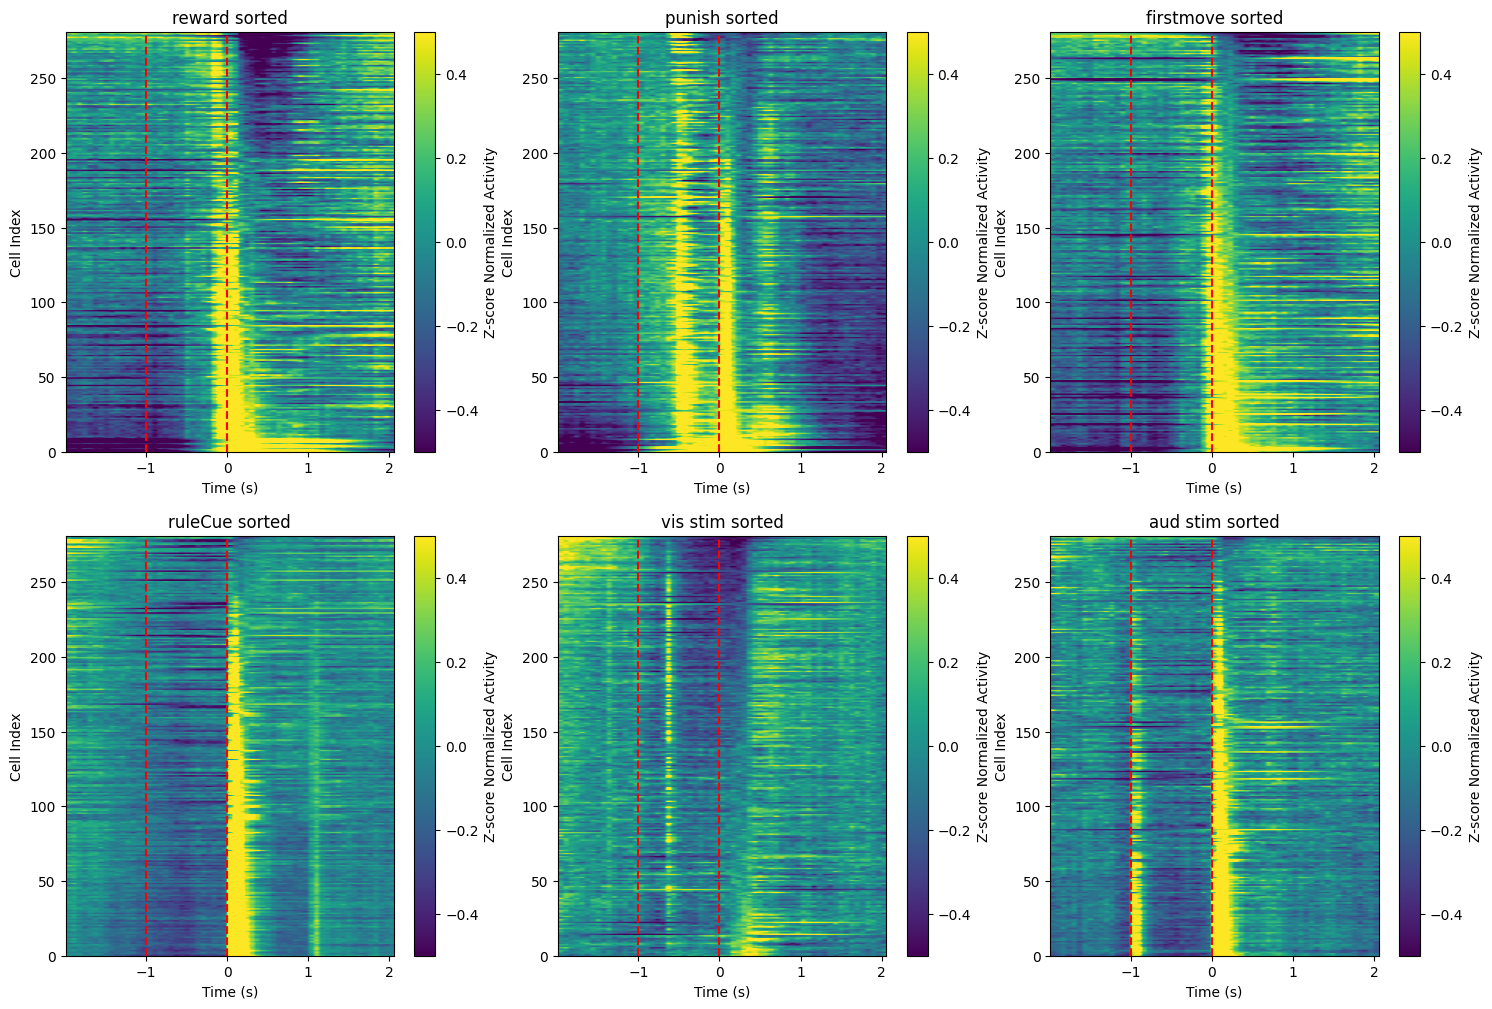

In [31]:
arm1_reward_sort_idx,_ = sort_psth_by_average_response(mean_arm1_reward_psth,0.5,frame_rate_arm1)
arm1_punish_sort_idx,_ = sort_psth_by_average_response(mean_arm1_punish_psth,0.5,frame_rate_arm1)
arm1_firstmove_sort_idx,_ = sort_psth_by_average_response(mean_arm1_firstmove_psth,0.5,frame_rate_arm1)
arm1_ruleCue_sort_idx,_ = sort_psth_by_average_response(mean_arm1_ruleCue_psth,0.5,frame_rate_arm1)
arm1_vis_stimon_sort_idx,_ = sort_psth_by_average_response(mean_arm1_vis_stimon_psth,0.5,frame_rate_arm1)
arm1_aud_stimon_sort_idx,_ = sort_psth_by_average_response(mean_arm1_aud_stimon_psth,0.5,frame_rate_arm1)
fig, axs = plt.subplots(2, 3, figsize=(18, 12))
psth2plot = [mean_arm1_reward_psth[arm1_reward_sort_idx,:], 
             mean_arm1_punish_psth[arm1_punish_sort_idx,:], 
             mean_arm1_firstmove_psth[arm1_firstmove_sort_idx,:], 
             mean_arm1_ruleCue_psth[arm1_ruleCue_sort_idx,:],
             mean_arm1_vis_stimon_psth[arm1_vis_stimon_sort_idx,:], 
             mean_arm1_aud_stimon_psth[arm1_aud_stimon_sort_idx,:], 
             ]
titles = ["reward sorted", "punish sorted", "firstmove sorted", "ruleCue sorted", "vis stim sorted", "aud stim sorted"]
for ax, mean_psth, title in zip(axs.flat, psth2plot, titles):
    plot_mean_psth(mean_psth, frame_rate_arm1, title, ax, vmin=-0.5, vmax=0.5)
    # Adding red arrow at time 0
    ax.axvline(x=0, color='red', linestyle='--')
    ax.axvline(x=-tasksettings['RULE_TIMER'], color='red', linestyle='--')
    # ax.annotate('Start', xy=(0, 0.9), xytext=(0, 0.9), textcoords='axes fraction',
    #             arrowprops=dict(facecolor='red', shrink=0.05),
    #             horizontalalignment='right', verticalalignment='top', fontsize=14, color='red')

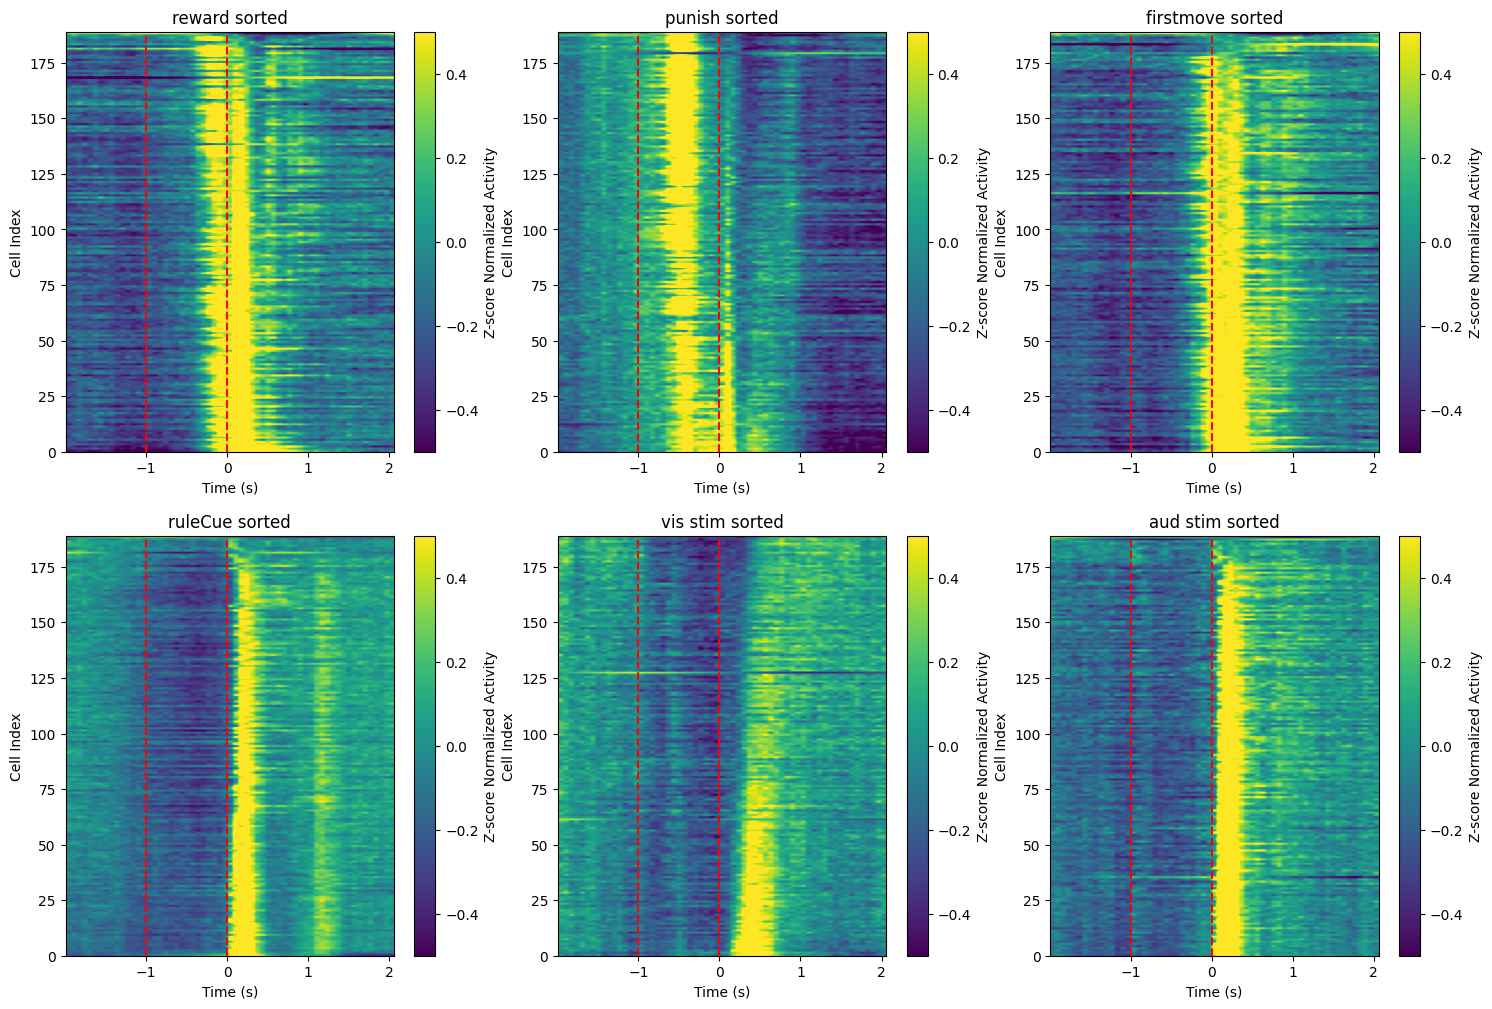

In [32]:
arm2_reward_sort_idx,_ = sort_psth_by_average_response(mean_arm2_reward_psth,0.5,frame_rate_arm2)
arm2_punish_sort_idx,_ = sort_psth_by_average_response(mean_arm2_punish_psth,0.5,frame_rate_arm2)
arm2_firstmove_sort_idx,_ = sort_psth_by_average_response(mean_arm2_firstmove_psth,0.5,frame_rate_arm2)
arm2_ruleCue_sort_idx,_ = sort_psth_by_average_response(mean_arm2_ruleCue_psth,0.5,frame_rate_arm2)
arm2_vis_stimon_sort_idx,_ = sort_psth_by_average_response(mean_arm2_vis_stimon_psth,0.5,frame_rate_arm2)
arm2_aud_stimon_sort_idx,_ = sort_psth_by_average_response(mean_arm2_aud_stimon_psth,0.5,frame_rate_arm2)
fig, axs = plt.subplots(2, 3, figsize=(18, 12))
psth2plot = [mean_arm2_reward_psth[arm2_reward_sort_idx,:], 
             mean_arm2_punish_psth[arm2_punish_sort_idx,:], 
             mean_arm2_firstmove_psth[arm2_firstmove_sort_idx,:], 
             mean_arm2_ruleCue_psth[arm2_ruleCue_sort_idx,:],
             mean_arm2_vis_stimon_psth[arm2_vis_stimon_sort_idx,:], 
             mean_arm2_aud_stimon_psth[arm2_aud_stimon_sort_idx,:], 
             ]
titles = ["reward sorted", "punish sorted", "firstmove sorted", "ruleCue sorted", "vis stim sorted", "aud stim sorted"]
for ax, mean_psth, title in zip(axs.flat, psth2plot, titles):
    plot_mean_psth(mean_psth, frame_rate_arm2, title, ax, vmin=-0.5, vmax=0.5)
    # Adding red arrow at time 0
    ax.axvline(x=0, color='red', linestyle='--')
    ax.axvline(x=-tasksettings['RULE_TIMER'], color='red', linestyle='--')
    # ax.annotate('Start', xy=(0, 0.9), xytext=(0, 0.9), textcoords='axes fraction',
    #             arrowprops=dict(facecolor='red', shrink=0.05),
    #             horizontalalignment='right', verticalalignment='top', fontsize=14, color='red')

vis reward vs. aud reward

In [44]:
vis_aud_reward_diff = mean_arm1_vis_reward_psth-mean_arm1_aud_reward_psth
midpoint = vis_aud_reward_diff.shape[1]//2+1
mean_vis_aud_reward_diff = np.mean(vis_aud_reward_diff[:,midpoint+1:midpoint+10],axis=1)
big_diff_cell_ind = np.where(np.abs(mean_vis_aud_reward_diff)>0.2)[0]
len(big_diff_cell_ind)

4

In [ ]:
zone1_xbound = [0, 700]
zone1_ybound = [595, 730]
zone2_xbound = [0, 700.0]
zone2_ybound = [775, 950]

zone1_idx = [
    idx for idx in range(len(arm1_stat))
    if (
        (arm1_stat[idx]['med'][0] > zone1_xbound[0]) and 
        (arm1_stat[idx]['med'][0] < zone1_xbound[1]) and
        (arm1_stat[idx]['med'][1] > zone1_ybound[0]) and 
        (arm1_stat[idx]['med'][1] < zone1_ybound[1])
    )
]
zone2_idx = [
    idx for idx in range(len(arm1_stat))
    if (
        (arm1_stat[idx]['med'][0] > zone2_xbound[0]) and 
        (arm1_stat[idx]['med'][0] < zone2_xbound[1]) and
        (arm1_stat[idx]['med'][1] > zone2_ybound[0]) and 
        (arm1_stat[idx]['med'][1] < zone2_ybound[1])
    )
]

plot_roi_masks((1024,1024), arm1_stat, zone1_idx)
plot_roi_masks((1024,1024), arm1_stat, zone2_idx)


In [ ]:
fig, axs = plt.subplots(8, 8, figsize=(18, 12))
cell_ind2plot = big_diff_cell_ind
vis_reward_psth2plot = [arm1_vis_reward_psth[:,i,:] for i in cell_ind2plot
             ]
aud_reward_psth2plot = [arm1_aud_reward_psth[:,i,:] for i in cell_ind2plot
             ]
titles = ["cell#"+str(i) for i in cell_ind2plot]
timepoints = np.arange(-2000,2000,66)
for ax, vis_psth, aud_psth, title in zip(axs.flat, vis_reward_psth2plot, aud_reward_psth2plot, titles):
    plot_with_error_shading(vis_psth, timepoints, ax, title, 'blue')
    plot_with_error_shading(aud_psth, timepoints, ax, title, 'red')
plt.tight_layout()

In [ ]:
fig, axs = plt.subplots(8, 8, figsize=(18, 12))
cell_ind2plot = np.arange(64)
leftchoice_reward_psth2plot = [arm1_leftchoice_reward_psth[:,i,:] for i in cell_ind2plot
             ]
rightchoice_reward_psth2plot = [arm1_rightchoice_reward_psth[:,i,:] for i in cell_ind2plot
             ]
titles = ["cell#"+str(i) for i in cell_ind2plot]
timepoints = np.arange(-2000,2000,66)
for ax, leftchoice_psth, rightchoice_psth, title in zip(axs.flat, leftchoice_reward_psth2plot, rightchoice_reward_psth2plot, titles):
    plot_with_error_shading(leftchoice_psth, timepoints, ax, title, 'blue')
    plot_with_error_shading(rightchoice_psth, timepoints, ax, title, 'red')
plt.tight_layout()

In [ ]:
fig, axs = plt.subplots(7, 7, figsize=(12, 12))
cell_ind2plot = arm1_pc_idx
pc_reward_psth2plot = [arm1_reward_psth[:,i,:] for i in cell_ind2plot
             ]
pc_vis_psth2plot = [arm1_vis_stimon_psth[:,i,:] for i in cell_ind2plot
             ]

titles = ["soma#"+str(arm1_stat[i]['id']) for i in cell_ind2plot]
timepoints = np.arange(-2000,2000,66)
for ax, pc_vis_psth, title in zip(axs.flat, pc_vis_psth2plot, titles):
    plot_with_error_shading(pc_vis_psth, timepoints, ax, title, 'blue')
plt.tight_layout()

<h3>Load Behavior Traces</h3>

In [77]:
facemap_folder = os.path.join(bhv_path, 'raw_video_data', 'facemap')


In [18]:
try:
    pupil_area = np.load(os.path.join(facemap_folder, 'pupil_area.npy'))
    pupil_xpos = np.load(os.path.join(facemap_folder, 'pupil_xpos.npy'))
    pupil_ypos = np.load(os.path.join(facemap_folder, 'pupil_ypos.npy'))
    body_motion = np.load(os.path.join(facemap_folder, 'bodymotion_svd.npy'))
    face_motion = np.load(os.path.join(facemap_folder, 'facemotion_svd.npy'))
    lick = np.load(os.path.join(facemap_folder, 'lickmotion_svd.npy'))
except:
    facemap_out = np.load(os.path.join(facemap_folder, '_iblrig_leftCamera.raw_proc.npy'), allow_pickle=True).item()
    np.save(os.path.join(facemap_folder, 'pupil_area'), facemap_out['pupil'][0]['area_smooth'])
    np.save(os.path.join(facemap_folder, 'pupil_xpos'), facemap_out['pupil'][0]['com'][:,0])
    np.save(os.path.join(facemap_folder, 'pupil_ypos'), facemap_out['pupil'][0]['com'][:,1])
    np.save(os.path.join(facemap_folder, 'bodymotion_svd'), facemap_out['motSVD'][1])
    np.save(os.path.join(facemap_folder, 'lickmotion_svd'), facemap_out['motSVD'][2])
    np.save(os.path.join(facemap_folder, 'facemotion_svd'), facemap_out['motSVD'][3])

In [59]:
pupil_area.shape

(169765,)

In [19]:
table_for_video = pd.read_csv(bhv_path+'\\table_for_video.csv')
table_for_video

intervals_0  intervals_1  ruleCue_times  ruleCueTrigger_times  \
0              0          446             53                    52   
1            551          744            592                   590   
2            818         1699           1311                  1309   
3           1786         2178           1895                  1893   
4           2261         2674           2335                  2333   
..           ...          ...            ...                   ...   
309       145656       146772         145733                145731   
310       146850       147933         146886                146884   
311       148014       148847         148056                148054   
312       148927       149264         149021                149019   
313       149341       150973         149397                149396   

     response_times  choice  stimOnTrigger_times  stimOn_times  contrastLeft  \
0               353      -1                  101           113           NaN   
1               650      -1                  638           641           NaN   
2              1485       1                 1458          1461           NaN   
3              1964       1                 1941          1944           NaN   
4              2581       1                 2542          2544           1.0   
..              ...     ...                  ...           ...           ...   
309          146557       1               145779        145782           NaN   
310          147839      -1               146932        146936           NaN   
311          148754      -1               148103        148106           NaN   
312          149170       1               149149        149151           0.0   
313          150758       1               149444        149447           NaN   

     contrastRight  feedback_times  feedbackType  rewardVolume  \
0              0.5             353             1           3.0   
1              0.5             650             1           3.0   
2              1.0            1314            -1           0.0   
3              1.0            1898            -1           0.0   
4              NaN            2581             1           3.0   
..             ...             ...           ...           ...   
309            1.0          145736            -1           0.0   
310            0.0          147839             1           3.0   
311            0.0          148754             1           3.0   
312            NaN          149170             1           3.0   
313            0.0          149400            -1           0.0   

     probabilityLeft  firstMovement_times  modality  
0               0.50                  344         0  
1               0.50                  631         0  
2               0.50                    0         0  
3               0.95                    0         0  
4               0.90                 2562         0  
..               ...                  ...       ...  
309             0.50                    0         0  
310             0.30               147501         1  
311             0.50               148660         1  
312             0.50               149159         1  
313             0.50                    0         1  

[314 rows x 16 columns]

In [20]:
video_start = table_for_video['ruleCue_times'][0]
video_end = table_for_video['intervals_1'].iloc[-1]
print(f'video start: {video_start} frame, video end: {video_end} frame')


video start: 53 frame, video end: 150973 frame


In [21]:
pupil_area = pupil_area[video_start:video_end+1]
pupil_xpos = pupil_xpos[video_start:video_end+1]
pupil_ypos = pupil_ypos[video_start:video_end+1]
body_motion = body_motion[video_start:video_end+1,:]
lick = lick[video_start:video_end+1,:]
face_motion = face_motion[video_start:video_end+1,:]

In [22]:
lick.shape

(150921, 83)

In [23]:
arm1_table_for_img

intervals_0  intervals_1  ruleCue_times  ruleCueTrigger_times  \
0            132          298            199                   198   
1            324          373            334                   334   
2            391          613            515                   515   
3            635          734            662                   662   
4            755          859            773                   773   
..           ...          ...            ...                   ...   
309        36862        37143          36882                 36881   
310        37163        37435          37172                 37171   
311        37456        37666          37466                 37466   
312        37686        37771          37709                 37709   
313        37790        38201          37804                 37804   

     response_times  choice  stimOnTrigger_times  stimOn_times  contrastLeft  \
0               274      -1                  210           214           NaN   
1               349      -1                  346           347           NaN   
2               559       1                  552           553           NaN   
3               680       1                  674           675           NaN   
4               835       1                  825           826           1.0   
..              ...     ...                  ...           ...           ...   
309           37089       1                36893         36894           NaN   
310           37412      -1                37183         37184           NaN   
311           37642      -1                37478         37479           NaN   
312           37747       1                37741         37742           0.0   
313           38147       1                37816         37817           NaN   

     contrastRight  feedback_times  feedbackType  rewardVolume  \
0              0.5             274             1           3.0   
1              0.5             349             1           3.0   
2              1.0             516            -1           0.0   
3              1.0             663            -1           0.0   
4              NaN             835             1           3.0   
..             ...             ...           ...           ...   
309            1.0           36882            -1           0.0   
310            0.0           37412             1           3.0   
311            0.0           37642             1           3.0   
312            NaN           37747             1           3.0   
313            0.0           37805            -1           0.0   

     probabilityLeft  firstMovement_times  modality  vis_stimOn_times  \
0               0.50                272.0         0             214.0   
1               0.50                344.0         0             347.0   
2               0.50                  NaN         0             553.0   
3               0.95                  NaN         0             675.0   
4               0.90                831.0         0             826.0   
..               ...                  ...       ...               ...   
309             0.50                  NaN         0           36894.0   
310             0.30              37327.0         1               NaN   
311             0.50              37618.0         1               NaN   
312             0.50              37744.0         1               NaN   
313             0.50                  NaN         1               NaN   

     aud_stimOn_times  
0                 NaN  
1                 NaN  
2                 NaN  
3                 NaN  
4                 NaN  
..                ...  
309               NaN  
310           37185.0  
311           37479.0  
312           37743.0  
313           37817.0  

[314 rows x 18 columns]

In [24]:
frame_rate_arm1

15.0793

In [25]:
arm1_dff_for_video = arm1_dff[:,arm1_table_for_img['ruleCue_times'][0]:arm1_table_for_img['intervals_1'].iloc[-1]]
arm1_dff_for_video.shape

(326, 38002)

In [26]:
sd_pupil_area = zscore(downsample_array(pupil_area,arm1_dff_for_video.shape[1],axis=0, method = 'interpolate'))
sd_lick = zscore(downsample_array(lick,arm1_dff_for_video.shape[1],axis=0, method = 'interpolate')).T
sd_body = zscore(downsample_array(body_motion,arm1_dff_for_video.shape[1],axis=0, method = 'interpolate')).T
sd_face = zscore(downsample_array(face_motion,arm1_dff_for_video.shape[1],axis=0, method = 'interpolate')).T


In [78]:
sd_lick.shape

(83, 38002)

In [41]:
correlation_matrix = np.corrcoef(sd_body[1], sd_face[1])
correlation = correlation_matrix[0, 1]
print(correlation)

0.05828110348766416


In [28]:
pca_components, explained_variance, pca_scores = perform_pca(arm1_dff_for_video, n_components=200)

In [61]:
print(sum(explained_variance))
print(pca_components.shape)
print(pca_scores.shape)

0.7775137643935351
(813, 200)
(200, 42590)


In [29]:
arm1_dff_for_video.shape

(326, 38002)

In [82]:
tf_arm1_table_for_img = transform_trial_table(arm1_table_for_img)
tf_arm1_table_for_img

intervals_0  intervals_1  ruleCue_times  ruleCueTrigger_times  \
0            132          298            199                   198   
1            324          373            334                   334   
2            391          613            515                   515   
3            635          734            662                   662   
4            755          859            773                   773   
..           ...          ...            ...                   ...   
309        36862        37143          36882                 36881   
310        37163        37435          37172                 37171   
311        37456        37666          37466                 37466   
312        37686        37771          37709                 37709   
313        37790        38201          37804                 37804   

     response_times  choice  stimOnTrigger_times  stimOn_times  contrastLeft  \
0               274      -1                  210           214           NaN   
1               349      -1                  346           347           NaN   
2               559       1                  552           553           NaN   
3               680       1                  674           675           NaN   
4               835       1                  825           826           1.0   
..              ...     ...                  ...           ...           ...   
309           37089       1                36893         36894           NaN   
310           37412      -1                37183         37184           NaN   
311           37642      -1                37478         37479           NaN   
312           37747       1                37741         37742           0.0   
313           38147       1                37816         37817           NaN   

     contrastRight  ...  reward_times  punish_times  visual_trial  aud_trial  \
0              0.5  ...         274.0           NaN             1          0   
1              0.5  ...         349.0           NaN             1          0   
2              1.0  ...           NaN         560.0             1          0   
3              1.0  ...           NaN         680.0             1          0   
4              NaN  ...         835.0           NaN             1          0   
..             ...  ...           ...           ...           ...        ...   
309            1.0  ...           NaN       37089.0             1          0   
310            0.0  ...       37412.0           NaN             0          1   
311            0.0  ...       37642.0           NaN             0          1   
312            NaN  ...       37747.0           NaN             0          1   
313            0.0  ...           NaN       38147.0             0          1   

     left_vis_stimOn_times  right_vis_stimOn_times  left_aud_stimOn_times  \
0                      NaN                   214.0                    NaN   
1                      NaN                   347.0                    NaN   
2                      NaN                   553.0                    NaN   
3                      NaN                   675.0                    NaN   
4                    826.0                     NaN                    NaN   
..                     ...                     ...                    ...   
309                    NaN                 36894.0                    NaN   
310                    NaN                     NaN                    NaN   
311                    NaN                     NaN                    NaN   
312                    NaN                     NaN                37743.0   
313                    NaN                     NaN                    NaN   

     right_aud_stimOn_times  previous_feedbackType  reward_history  
0                       NaN                      0            0.55  
1                       NaN                      1            0.55  
2                       NaN                      1            0.55  
3                       NaN              

In [196]:
event_variable_names = ['ruleCue_times', 'left_vis_stimOn_times', 'right_vis_stimOn_times', 'left_aud_stimOn_times', 'right_aud_stimOn_times', 'reward_times', 'punish_times'] 
whole_variable_names = ['leftchoice', 'rightchoice', 'previous_feedbackType', 'reward_history']
#event_windows = [(0,0.2), (0,0.5), (0,0.5), (0,0.2), (0,0.5), (0,0), (0,0),(0,0), (0,0)]

In [197]:
event_arrays = generate_event_windows(df = tf_arm1_table_for_img, column_names=event_variable_names, event_type='peri')
aligned_event_arrays = []
for array in event_arrays:
    new_array = np.delete(array, np.arange(arm1_table_for_img['ruleCue_times'][0]))
    aligned_event_arrays.append(new_array)
shifted_event_predictors, shifted_event_predictor_names = shift_predictors(predictors_list=aligned_event_arrays, predictor_names=event_variable_names, window=(0.4,1), frame_rate=frame_rate_arm1)

In [198]:
whole_arrays = generate_event_windows(df = tf_arm1_table_for_img, column_names=whole_variable_names, event_type='whole')
aligned_whole_arrays = []
for array in whole_arrays:
    new_array = np.delete(array, np.arange(arm1_table_for_img['ruleCue_times'][0]))
    aligned_whole_arrays.append(new_array)

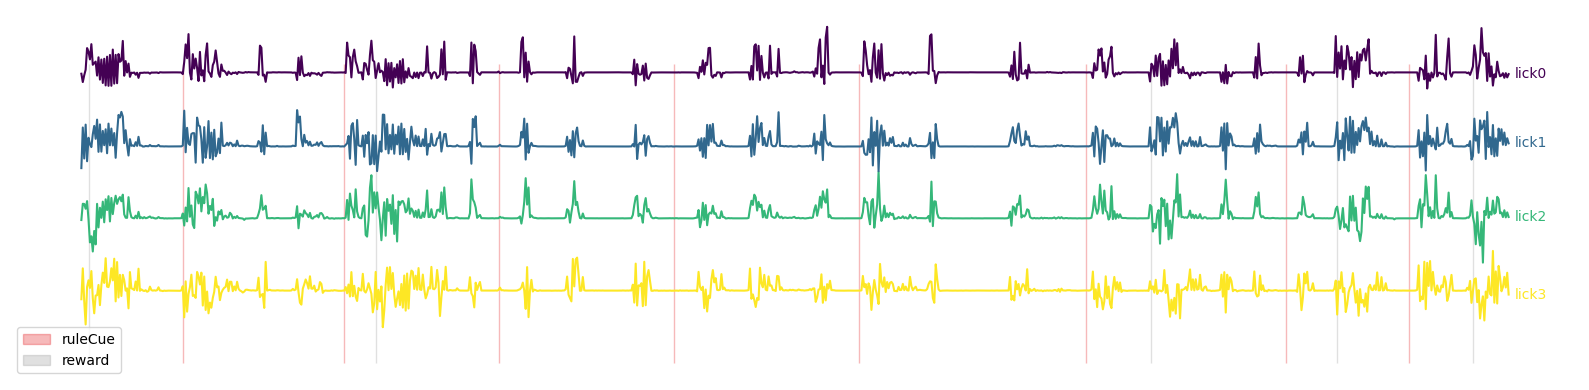

In [195]:
traces = [sd_lick[0,:], sd_lick[1,:],sd_lick[2,:],sd_lick[3,:]]
labels = ['lick0','lick1','lick2','lick3']
toplot_events = ['ruleCue','reward']
toplot_event_arrays = [aligned_event_arrays[0], aligned_event_arrays[5]]
plot_aligned_traces(traces = traces, plot_indices=np.arange(2000,3000), labels=labels, event_arrays=toplot_event_arrays, event_labels=toplot_events, figsize=(16,4))

In [ ]:
traces = [pca_scores[0,:], pca_scores[1,:], pca_scores[2,:], pca_scores[3,:], pca_scores[5,:], sd_body[0,:], sd_lick[0,:], sd_pupil_area, aligned_event_arrays[7],aligned_event_arrays[8]]
labels = ['pca_comp1', 'pca_comp2', 'pca_comp3', 'pca_comp4', 'pca_comp5', 'body', 'lick', 'pupil', 'left choice','right choice']
toplot_events = ['ruleCue','punish']
toplot_event_arrays = [aligned_event_arrays[0], aligned_event_arrays[6]]
plot_aligned_traces(traces = traces, plot_indices=np.arange(3000,4000), labels=labels, event_arrays=toplot_event_arrays, event_labels=toplot_events, figsize=(16,4))

In [ ]:
spline_basis_functions = generate_spline_basis_functions(num_basis=7, window_length=2, frame_rate=frame_rate_arm1)
convolved_event_predictors, convolved_event_predictor_names = convolve_event_with_splines(event_traces=aligned_event_arrays[:7], basis_functions=spline_basis_functions, names = column_names[:7])

In [199]:
body_motion_variables, body_names = transform_continuous_variable(sd_body[0:50], 'body')
lick_motion_variables, lick_names = transform_continuous_variable(sd_lick[0:10], 'lick')
face_motion_variables, face_names = transform_continuous_variable(sd_face[0:50], 'face')

continuous_variables = []
continuous_variables_names = []
continuous_variables.extend(body_motion_variables)
continuous_variables.extend(lick_motion_variables)
continuous_variables.extend(face_motion_variables)
continuous_variables.extend([sd_pupil_area])

continuous_variables_names.extend(body_names)
continuous_variables_names.extend(lick_names)
continuous_variables_names.extend(face_names)
continuous_variables_names.extend(['pupil'])

In [ ]:
convolved_design_matrix, convolved_predictor_names = construct_design_matrix(event_predictors_list=convolved_event_predictors,
                                                         event_predictor_names=convolved_event_predictor_names,
                                                         whole_trial_predictors=whole_variables,
                                                         whole_trial_predictor_names=whole_variables_names,
                                                         continuous_predictors_list=continuous_variables,
                                                         continuous_predictor_names=continuous_variables_names)
print(convolved_design_matrix.shape)
print(len(convolved_predictor_names))
print(convolved_predictor_names)
convolved_model_ridge_beta, convolved_model_ridge_intercepts, convolved_model_ridge_explained_variance = encoding_model(arm1_dff_for_video, convolved_design_matrix, regression_type='ridge', alpha=1)

(38002, 164)
164
['ruleCue_times_bf_0', 'ruleCue_times_bf_1', 'ruleCue_times_bf_2', 'ruleCue_times_bf_3', 'ruleCue_times_bf_4', 'ruleCue_times_bf_5', 'ruleCue_times_bf_6', 'left_vis_stimOn_times_bf_0', 'left_vis_stimOn_times_bf_1', 'left_vis_stimOn_times_bf_2', 'left_vis_stimOn_times_bf_3', 'left_vis_stimOn_times_bf_4', 'left_vis_stimOn_times_bf_5', 'left_vis_stimOn_times_bf_6', 'right_vis_stimOn_times_bf_0', 'right_vis_stimOn_times_bf_1', 'right_vis_stimOn_times_bf_2', 'right_vis_stimOn_times_bf_3', 'right_vis_stimOn_times_bf_4', 'right_vis_stimOn_times_bf_5', 'right_vis_stimOn_times_bf_6', 'left_aud_stimOn_times_bf_0', 'left_aud_stimOn_times_bf_1', 'left_aud_stimOn_times_bf_2', 'left_aud_stimOn_times_bf_3', 'left_aud_stimOn_times_bf_4', 'left_aud_stimOn_times_bf_5', 'left_aud_stimOn_times_bf_6', 'right_aud_stimOn_times_bf_0', 'right_aud_stimOn_times_bf_1', 'right_aud_stimOn_times_bf_2', 'right_aud_stimOn_times_bf_3', 'right_aud_stimOn_times_bf_4', 'right_aud_stimOn_times_bf_5', 'righ

In [200]:
design_matrix, predictor_names = construct_design_matrix(event_predictors_list=shifted_event_predictors,
                                                         event_predictor_names=shifted_event_predictor_names,
                                                         whole_trial_predictors=aligned_whole_arrays,
                                                         whole_trial_predictor_names=whole_variable_names,
                                                         continuous_predictors_list=continuous_variables,
                                                         continuous_predictor_names=continuous_variables_names)
print(design_matrix.shape)
print(len(predictor_names))
print(predictor_names)

(38002, 269)
269
['backward_6frame_ruleCue_times', 'backward_5frame_ruleCue_times', 'backward_4frame_ruleCue_times', 'backward_3frame_ruleCue_times', 'backward_2frame_ruleCue_times', 'backward_1frame_ruleCue_times', 'ruleCue_times', 'forward_1frame_ruleCue_times', 'forward_2frame_ruleCue_times', 'forward_3frame_ruleCue_times', 'forward_4frame_ruleCue_times', 'forward_5frame_ruleCue_times', 'forward_6frame_ruleCue_times', 'forward_7frame_ruleCue_times', 'forward_8frame_ruleCue_times', 'forward_9frame_ruleCue_times', 'forward_10frame_ruleCue_times', 'forward_11frame_ruleCue_times', 'forward_12frame_ruleCue_times', 'forward_13frame_ruleCue_times', 'forward_14frame_ruleCue_times', 'forward_15frame_ruleCue_times', 'backward_6frame_left_vis_stimOn_times', 'backward_5frame_left_vis_stimOn_times', 'backward_4frame_left_vis_stimOn_times', 'backward_3frame_left_vis_stimOn_times', 'backward_2frame_left_vis_stimOn_times', 'backward_1frame_left_vis_stimOn_times', 'left_vis_stimOn_times', 'forward_1

In [207]:
ridge_beta, ridge_intercepts, ridge_explained_variance = encoding_model(arm1_dff_for_video, design_matrix, regression_type='ridge', alpha=1)

In [202]:
ruleCue_kernels_idx = [i for i in range(len(predictor_names)) if 'ruleCue_times' in predictor_names[i]]
left_vis_stimOn_kernels_idx = [i for i in range(len(predictor_names)) if 'left_vis_stimOn_times' in predictor_names[i]]
right_vis_stimOn_kernels_idx = [i for i in range(len(predictor_names)) if 'right_vis_stimOn_times' in predictor_names[i]]
left_aud_stimOn_kernels_idx = [i for i in range(len(predictor_names)) if 'left_aud_stimOn_times' in predictor_names[i]]
right_aud_stimOn_kernels_idx = [i for i in range(len(predictor_names)) if 'right_aud_stimOn_times' in predictor_names[i]]
reward_kernels_idx = [i for i in range(len(predictor_names)) if 'reward_times' in predictor_names[i]]
punish_kernels_idx = [i for i in range(len(predictor_names)) if 'punish_times' in predictor_names[i]]

ruleCue_beta = ridge_beta[:,ruleCue_kernels_idx]
left_vis_stimOn_beta = ridge_beta[:,left_vis_stimOn_kernels_idx]
right_vis_stimOn_beta = ridge_beta[:,right_vis_stimOn_kernels_idx]
left_aud_stimOn_beta = ridge_beta[:,left_aud_stimOn_kernels_idx]
right_aud_stimOn_beta = ridge_beta[:,right_aud_stimOn_kernels_idx]
reward_beta = ridge_beta[:,reward_kernels_idx]
punish_beta = ridge_beta[:,punish_kernels_idx]

In [86]:
def plot_roi_masks(ax=None, dim=(1024, 1024), roi_stat=None, roi_index=None, roi_data=None, vmin=None, vmax=None):
    """
    Plot ROI masks on an image.

    Parameters:
    ax (matplotlib.axes.Axes): The axis to plot on. If None, a new figure will be created.
    dim (tuple): The dimensions of the image (default is 1024x1024).
    roi_stat (list): List containing ROI statistics (each element contains 'ypix' and 'xpix').
    roi_index (list): List of indices to select ROIs to plot.
    roi_data (list or np.ndarray): Data to plot for each ROI (must match the size of roi_index).
    vmin, vmax (float): Min and max values for scaling the color map.

    Returns:
    im (matplotlib.image.AxesImage): The image object, used for colorbar creation.
    """
    im = np.zeros(dim)
    if roi_index is None or roi_stat is None:
        print("index for rois or roi stat cannot be none!")
        return
    
    # Fill in the pixels for each ROI
    for idx in roi_index:
        ypix = roi_stat[idx]['ypix']
        xpix = roi_stat[idx]['xpix']
        if roi_data is not None:
            im[ypix, xpix] = roi_data[idx]
        else:
            im[ypix, xpix] = 1
    
    # Plot the image
    if ax is None:
        fig, ax = plt.subplots()
        im_obj = ax.imshow(im, vmin=vmin, vmax=vmax)
        plt.show()
    else:
        im_obj = ax.imshow(im, vmin=vmin, vmax=vmax)
    
    # Return the image object for colorbar creation
    return im_obj

In [163]:
np.arange(1,23,3)

array([ 1,  4,  7, 10, 13, 16, 19, 22])

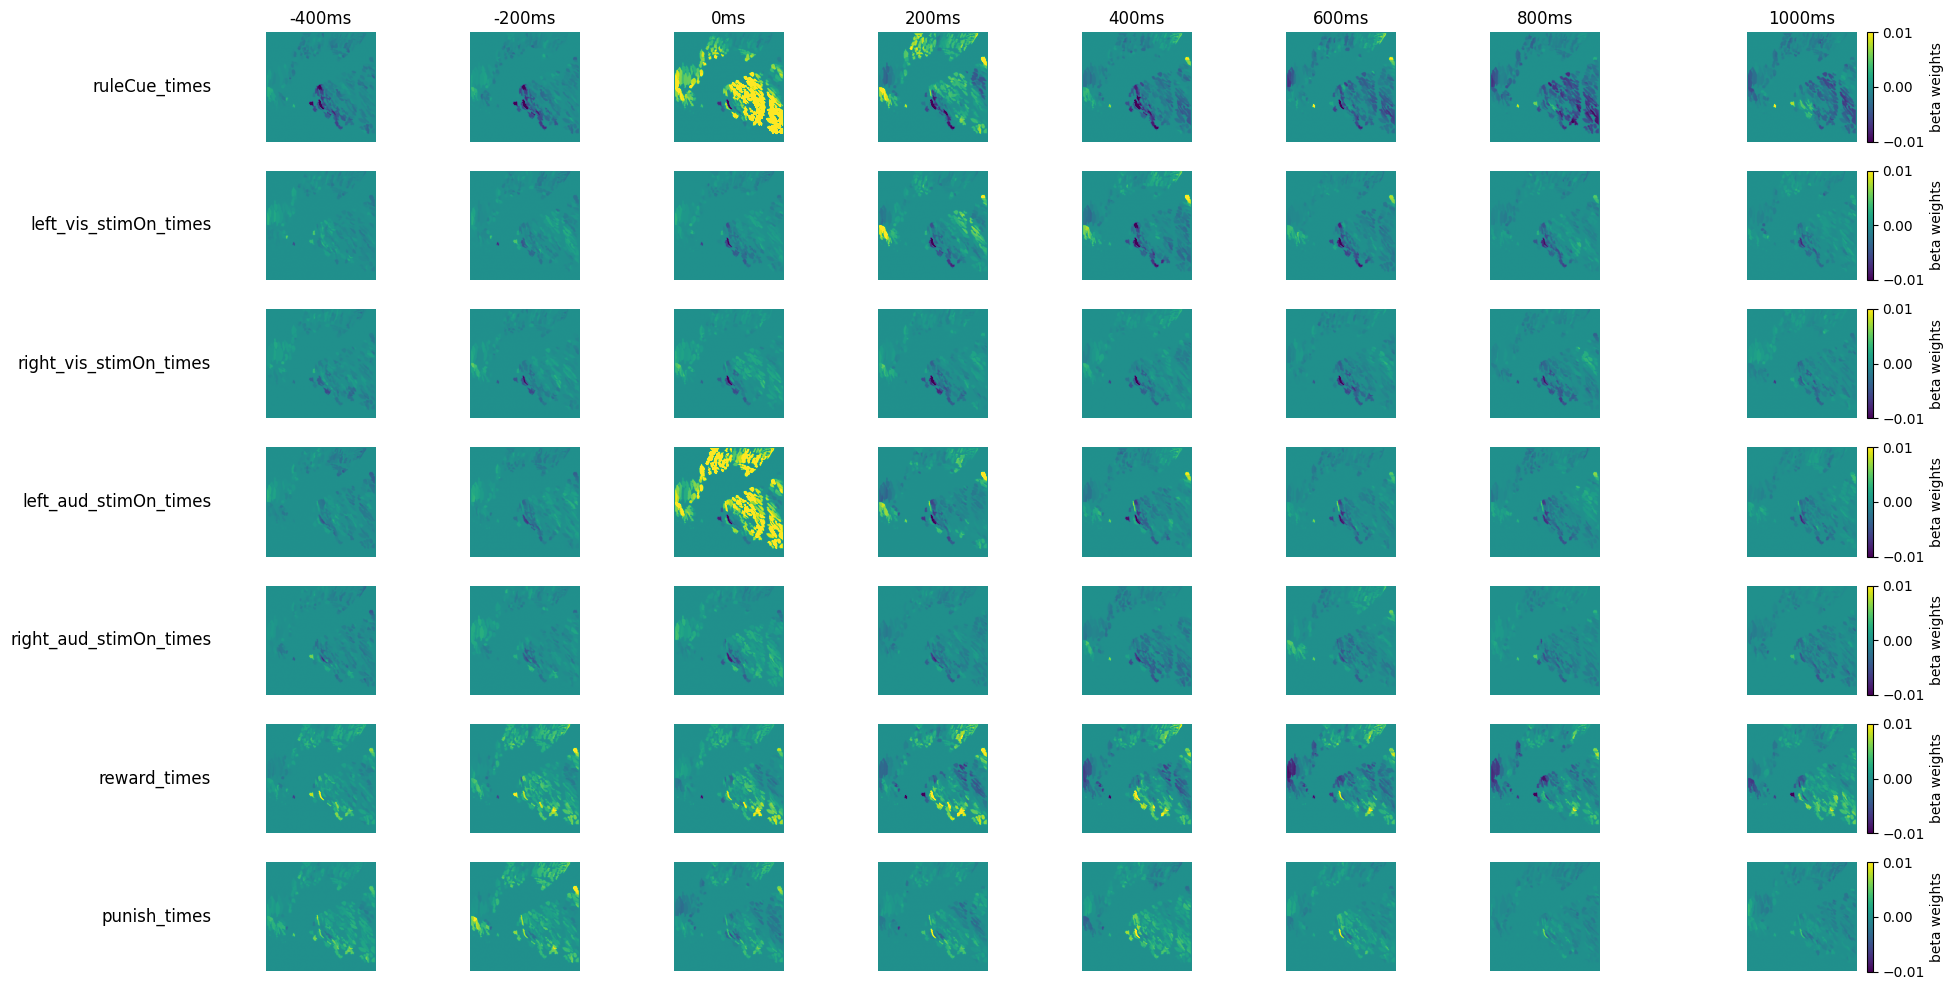

In [203]:
num_subplots = 8
timestepsize = 200
timesteps = np.arange(-400, 1001, timestepsize)
fig, axes = plt.subplots(7,num_subplots, figsize = (20,10))
toplot_idx = np.arange(0,22,3)

all_beta = [ruleCue_beta, left_vis_stimOn_beta, right_vis_stimOn_beta, left_aud_stimOn_beta, right_aud_stimOn_beta, reward_beta, punish_beta]
for rowi, data in enumerate(all_beta):
    for i in range(num_subplots):
        im = plot_roi_masks(ax=axes[rowi, i], roi_stat = arm1_stat, roi_index=np.arange(ridge_beta.shape[0]), roi_data = data[:,toplot_idx[i]], vmin=-1e-02, vmax=1e-02)
        axes[rowi, i].set_axis_off()
        if rowi==0: 
            axes[rowi, i].set_title(str(timesteps[i])+'ms')
    axes[rowi, 0].text(-0.5, 0.5, f'{event_variable_names[rowi]}', transform=axes[rowi, 0].transAxes, 
                    fontsize=12, va='center', ha='right')
    fig.colorbar(im, ax=axes[rowi, -1], fraction=0.046, pad=0.04, label='beta weights')
plt.tight_layout()
plt.show()

In [138]:
body_motion_kernels_idx = [i for i in range(len(predictor_names)) if 'body' in predictor_names[i]]
lick_motion_kernels_idx = [i for i in range(len(predictor_names)) if 'lick' in predictor_names[i]]
body_motion_beta = ridge_beta[:,body_motion_kernels_idx]
lick_motion_beta = ridge_beta[:,lick_motion_kernels_idx]

In [132]:
body_motion_beta.shape

(813, 5)

Text(-0.5, 0.5, 'licking motion')

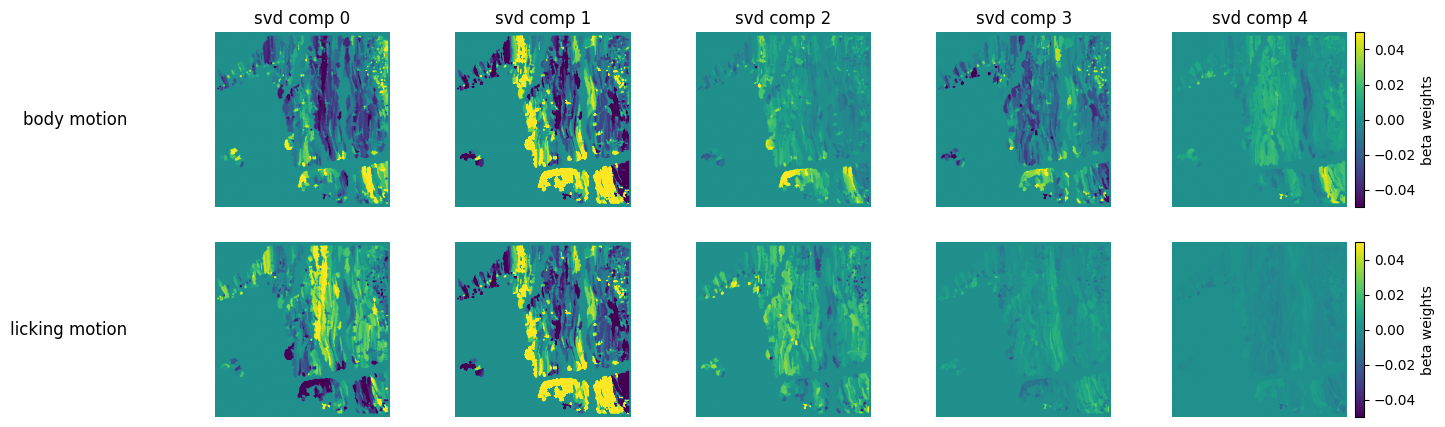

In [141]:
fig,axes = plt.subplots(2,5,figsize=(15,5))
for i in range(5):
    im1 = plot_roi_masks(ax=axes[0,i],roi_stat = arm1_stat, roi_index=np.arange(ridge_beta.shape[0]), roi_data = body_motion_beta[:,i], vmin=-5e-02, vmax=5e-02)
    axes[0,i].set_axis_off()
    axes[0,i].set_title(f'svd comp {i}')
        
    im2 = plot_roi_masks(ax=axes[1,i],roi_stat = arm1_stat, roi_index=np.arange(ridge_beta.shape[0]), roi_data = lick_motion_beta[:,i], vmin=-5e-02, vmax=5e-02)
    axes[1,i].set_axis_off()
fig.colorbar(im1, ax=axes[0, -1], fraction=0.046, pad=0.04, label='beta weights')
fig.colorbar(im2, ax=axes[1, -1], fraction=0.046, pad=0.04, label='beta weights')    

axes[0, 0].text(-0.5, 0.5, f'body motion', transform=axes[0, 0].transAxes, 
                    fontsize=12, va='center', ha='right')
axes[1, 0].text(-0.5, 0.5, f'licking motion', transform=axes[1, 0].transAxes, 
                    fontsize=12, va='center', ha='right')

In [147]:
ridge_beta_matrix, ridge_intercepts, ridge_explained_variance, ridge_reduced_explained_variances, ridge_F_stat = encoding_model_with_significance(arm1_dff_for_video, design_matrix, regression_type='ridge', alpha=1)


In [108]:
ridge_F_stat.shape

(813, 48)

In [148]:
import scipy.stats as stats
DF1 = 1
DF2 = arm1_dff_for_video.shape[1]-ridge_F_stat.shape[1]
p_values = stats.f.sf(ridge_F_stat, DF1, DF2)
num_tests = p_values.shape[1]  # Total number of tests (number of p-values)
bonferroni_p_values = np.minimum(p_values * num_tests, 1.0)  # Adjust p-values
significant_mask = bonferroni_p_values < 0.01

[Text(0, 0, 'ruleCue_times_bf_0'),
 Text(7, 0, 'vis_stimOn_times_bf_0'),
 Text(14, 0, 'aud_stimOn_times_bf_0'),
 Text(21, 0, 'reward_times_bf_0'),
 Text(28, 0, 'punish_times_bf_0'),
 Text(35, 0, 'leftchoice'),
 Text(36, 0, 'rightchoice'),
 Text(37, 0, 'previous_feedbackType'),
 Text(38, 0, 'reward_history'),
 Text(39, 0, 'body_comp_0'),
 Text(44, 0, 'lick_comp_0'),
 Text(49, 0, 'pupil')]

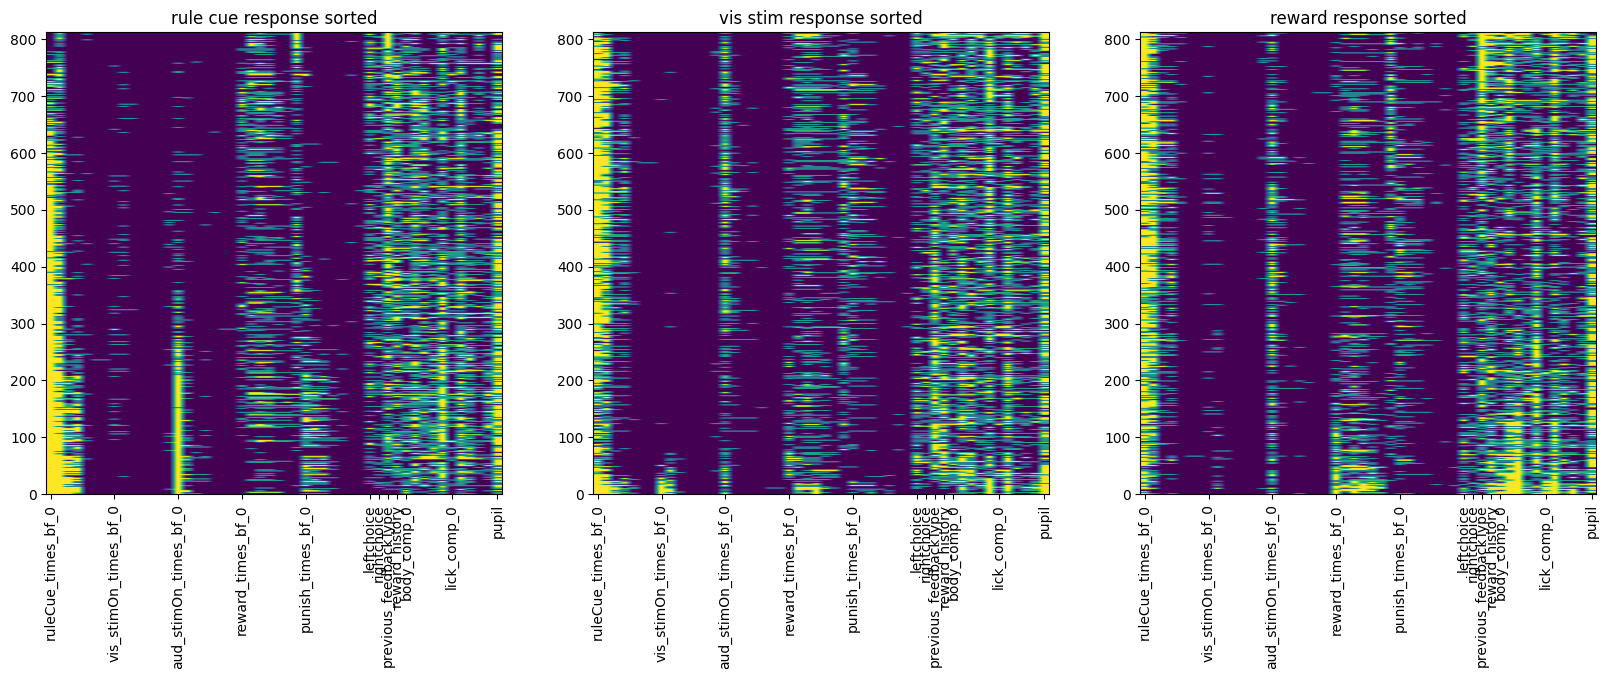

In [156]:
fig, axes = plt.subplots(1,3,figsize=(20,6))

axes[0].imshow(significant_mask[arm1_ruleCue_sort_idx,:],origin='lower',aspect='auto')
xlabel2plot = [0, 7, 14, 21, 28, 35, 36, 37, 38, 39, 44, 49]
x_labels = [predictor_names[i] for i in xlabel2plot]
axes[0].set_xticks(xlabel2plot)
axes[0].set_title('rule cue response sorted')
axes[0].set_xticklabels(x_labels, rotation=90)

axes[1].imshow(significant_mask[arm1_vis_stimon_sort_idx,:],origin='lower',aspect='auto')
axes[1].set_xticks(xlabel2plot)
axes[1].set_title('vis stim response sorted')
axes[1].set_xticklabels(x_labels, rotation=90)



axes[2].imshow(significant_mask[arm1_reward_sort_idx,:],origin='lower',aspect='auto')
axes[2].set_xticks(xlabel2plot)
axes[2].set_title('reward response sorted')
axes[2].set_xticklabels(x_labels, rotation=90)

In [111]:
mc_arm1_path = r'Z:\TM_Lab\Edward\Cerebellum_Imaging\O_L3\20240415\suite2p\plane0\reg_tif\concatenated_top_images.tif'
mc_rightroi_path = r'Z:\TM_Lab\Edward\Cerebellum_Imaging\O_L3\20240415\suite2p\plane0\reg_tif\concatenated_bottom_images.tif'

In [112]:
def extract_raw_fluo(stat, raw_img_filepath):
    # using rois from suite2p identified using deep interp images to get raw fluorescence of those cells
    raw_img = load_tiff(raw_img_filepath)
    num_cells = len(stat)
    num_frames, x, y = raw_img.shape
    F_raw = np.zeros((num_cells, num_frames))
    for i in range(num_cells):
        num_pixels = len(stat[i]['xpix'])
        pixel_fluo = []
        for j in range(num_pixels):
            pixel_fluo.append(raw_img[:,stat[i]['xpix'][j], stat[i]['ypix'][j]].squeeze())
        mean_pixel_fluo = np.mean(np.stack(pixel_fluo, axis = 1), axis = 1)
        F_raw[i,:] = mean_pixel_fluo
    return F_raw
    

In [114]:
try:
    arm1_raw_fluo = np.load(arm1_suite2p_path+'\\F_raw.npy', allow_pickle=True)
except:
    arm1_raw_fluo = extract_raw_fluo(raw_arm1_stat, mc_arm1_path)
    np.save(arm1_suite2p_path+'\\F_raw.npy', arm1_raw_fluo, allow_pickle=True)
arm1_raw_fluo = arm1_raw_fluo[arm1_iscell,:]

In [115]:
try:
    rightroi_raw_fluo = np.load(rightroi_suite2p_path+'\\F_raw.npy', allow_pickle=True)
except:
    rightroi_raw_fluo = extract_raw_fluo(raw_rightroi_stat, mc_rightroi_path)
    np.save(rightroi_suite2p_path+'\\F_raw.npy', rightroi_raw_fluo, allow_pickle=True)
rightroi_raw_fluo = rightroi_raw_fluo[rightroi_iscell,:]

In [116]:

#arm1_raw_dff = calculate_dff_with_moving_percentile(arm1_raw_fluo, frame_rate, moving_window=20, percentile=25)
arm1_raw_dff = calculate_dff_with_percentile(arm1_raw_fluo, 10)
rightroi_raw_dff = calculate_dff_with_percentile(rightroi_raw_fluo, 10)

In [117]:
def butter_lowpass(cutoff, fs, order=5):
    nyq = 0.5 * fs  # Nyquist Frequency
    normal_cutoff = cutoff / nyq
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    return b, a
def lowpass_filter(data, cutoff, fs, order=5):
    b, a = butter_lowpass(cutoff, fs, order=order)
    y = lfilter(b, a, data)
    return y

def lowpass_filter_2d(data, cutoff, fs, order=5):
    filtered_data = np.zeros_like(data)
    for i in range(data.shape[0]):
        filtered_data[i, :] = lowpass_filter(data[i, :], cutoff, fs, order)
    return filtered_data



In [154]:
arm1_lf_fluo = lowpass_filter_2d(arm1_raw_fluo, 3, frame_rate)
#arm1_lf_dff = calculate_dff_with_moving_percentile(arm1_lf_fluo, frame_rate, moving_window=20, percentile=25)
arm1_lf_dff = calculate_dff_with_percentile(arm1_lf_fluo,10)
rightroi_lf_fluo = lowpass_filter_2d(rightroi_raw_fluo, 3, frame_rate)
#rightroi_lf_dff = calculate_dff_with_moving_percentile(rightroi_lf_fluo, frame_rate, moving_window=20, percentile=25)
rightroi_lf_dff = calculate_dff_with_percentile(rightroi_lf_fluo,10)

In [155]:
allroi_raw_dff = np.vstack([arm1_raw_dff,rightroi_raw_dff])
allroi_lf_dff = np.vstack([arm1_lf_dff,rightroi_lf_dff])

(array([42., 70., 68., 55., 44., 48., 39., 38., 27., 22., 11., 15., 23.,
         8., 10., 11.,  5.,  7.,  2.,  2.]),
 array([0.98601738, 1.02129875, 1.05658012, 1.09186149, 1.12714287,
        1.16242424, 1.19770561, 1.23298698, 1.26826835, 1.30354973,
        1.3388311 , 1.37411247, 1.40939384, 1.44467521, 1.47995659,
        1.51523796, 1.55051933, 1.5858007 , 1.62108207, 1.65636345,
        1.69164482]),
 <BarContainer object of 20 artists>)

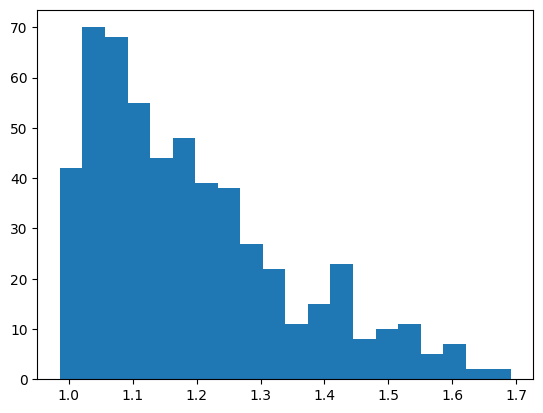

In [131]:
allroi_aspectratio = np.array([allroi_stat[x]['aspect_ratio'] for x in range(len(allroi_stat))])
plt.hist(allroi_aspectratio,bins = 20)

In [194]:
soma_idx = np.where(allroi_aspectratio < 1.05)[0]
dendrite_idx = np.where(allroi_aspectratio > 1.4)[0]

In [282]:
def plot_dff_traces(dff_trace, ax=None):
    """
    Plot dF/F traces with the y-axis representing the cells.

    Parameters:
    dff_trace (np.ndarray): 2D array of shape (cells, timepoints) containing dF/F traces.
    ax (matplotlib.axes._subplots.AxesSubplot, optional): Matplotlib axis object to plot on. 
                                                          If None, a new figure is created.

    Returns:
    None
    """
    num_cells, num_timepoints = dff_trace.shape
    
    if ax is None:
        fig, ax = plt.subplots(figsize=(15, num_cells // 2))

    for cell in range(num_cells):
        ax.plot(dff_trace[cell]*8 + cell * 10, label=f'Cell {cell + 1}')  # Offset each trace by cell index * 5
    
    ax.set_xlabel('Timepoints')
    ax.set_ylabel('Cells')
    ax.set_title('dF/F Traces for Each Cell')
    ax.set_yticks(np.arange(0, num_cells * 10, 10))
    ax.set_yticklabels([f'{i + 1}' for i in range(num_cells)])
    #ax.legend(loc='upper right', bbox_to_anchor=(1.15, 1), ncol=1)
    
    if ax is None:
        plt.show()

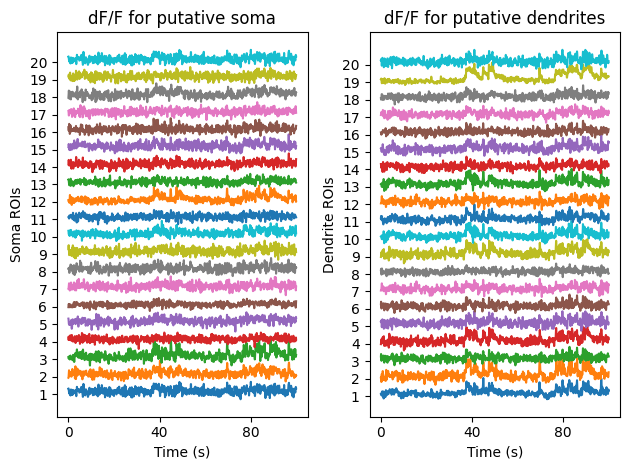

In [283]:
x = 20
plotidx = np.arange(14000,15500)
# Check if there are enough True values

# Randomly select x indices from the true_indices
soma_idx2plot = np.random.choice(soma_idx, size=x, replace=True)
dendrite_idx2plot = np.random.choice(dendrite_idx, size=x, replace=True)
fig, ax = plt.subplots(1,2)
soma_dff2plot = allroi_lf_dff[np.ix_(soma_idx2plot, plotidx)]
dendrite_dff2plot = allroi_lf_dff[np.ix_(dendrite_idx2plot, plotidx)]
plot_dff_traces(soma_dff2plot,ax[0])
plot_dff_traces(dendrite_dff2plot,ax[1])
ax[0].set_title('dF/F for putative soma')
ax[1].set_title('dF/F for putative dendrites')
ax[0].set_xticks(np.arange(0,len(plotidx)+1,600))
ax[0].set_xticklabels([str(40 * i) for i in range((len(plotidx)+1)//600+1)])
ax[0].set_xlabel('Time (s)')
ax[1].set_xticks(np.arange(0,len(plotidx)+1,600))
ax[1].set_xticklabels([str(40 * i) for i in range((len(plotidx)+1)//600+1)])
ax[1].set_xlabel('Time (s)')

ax[0].set_ylabel('Soma ROIs')
ax[1].set_ylabel('Dendrite ROIs')
plt.tight_layout()


In [284]:
fig.savefig(r'D:\Edward_projects\CAN_poster_2024\dff_trace.png', dpi=300)

Behavior Video

In [4]:
import random
def rgb_to_grayscale(rgb_image):
    return np.dot(rgb_image[..., :3], [0.2989, 0.5870, 0.1140])
def downsample_video_by_averaging(video, downsample_factor):
    """
    Downsample a video by averaging over pixel blocks.
    
    Parameters:
    - video: a 3D NumPy array with shape (frames, height, width) representing the grayscale video.
    - downsample_factor: a tuple (factor_height, factor_width) defining the
      downsampling factor for the height and width dimensions, respectively.
    
    Returns:
    - downsampled_video: the downsampled video as a NumPy array.
    """
    frames, height, width = video.shape

    # Calculate the size of the downsampled image
    new_height = height // downsample_factor[0]
    new_width = width // downsample_factor[1]

    # Check if the dimensions fit perfectly
    if height % downsample_factor[0] != 0 or width % downsample_factor[1] != 0:
        raise ValueError("Image dimensions must be divisible by the downsample factor.")

    # Reshape and average
    downsampled_video = video[:, :new_height * downsample_factor[0], :new_width * downsample_factor[1]]
    downsampled_video = downsampled_video.reshape(frames, new_height, downsample_factor[0], new_width, downsample_factor[1])
    downsampled_video = downsampled_video.mean(axis=(2, 4))

    return downsampled_video

In [17]:
paths = [
    #  r'Z:\TM_Lab\Edward\Cerebellum_Imaging\Pcp2-jgcamp8m\A_R2\20240815',
    #  r'Z:\TM_Lab\Edward\Cerebellum_Imaging\Pcp2-jgcamp8m\A_R2\20240821',
    # #  r'Z:\TM_Lab\Edward\Cerebellum_Imaging\Pcp2-jgcamp8m\A_R3\20240904',
    #  r'Z:\TM_Lab\Edward\Cerebellum_Imaging\Pcp2-jgcamp8m\A_R2\20240910',
    # #  r'Z:\TM_Lab\Edward\Cerebellum_Imaging\Pcp2-jgcamp8m\A_R3\20240918',
    #  r'Z:\TM_Lab\Edward\Cerebellum_Imaging\Pcp2-jgcamp8m\A_R2\20240924',
    #  r'Z:\TM_Lab\Edward\Cerebellum_Imaging\Pcp2-jgcamp8m\A_R2\20241015',
    #  r'Z:\TM_Lab\Edward\Cerebellum_Imaging\Pcp2-jgcamp8m\A_R2\20241018',
    #  r'Z:\TM_Lab\Edward\Cerebellum_Imaging\Pcp2-jgcamp8m\A_R2\20241106',
    #  r'Z:\TM_Lab\Edward\Cerebellum_Imaging\Pcp2-jgcamp8m\A_R3\20241111',
    #  #r'Z:\TM_Lab\Edward\Cerebellum_Imaging\Pcp2-jgcamp8m\A_L2\20241115',
     r'Z:\TM_Lab\Edward\Cerebellum_Imaging\Pcp2-jgcamp8m\J_L2\20241118',
    #  r'Z:\TM_Lab\Edward\Cerebellum_Imaging\Pcp2-jgcamp8m\A_R3\20241119',
     
]

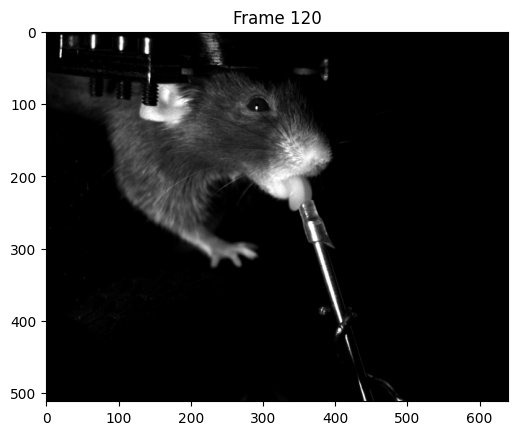

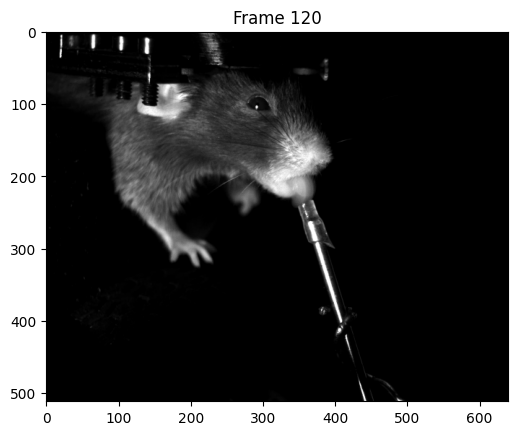

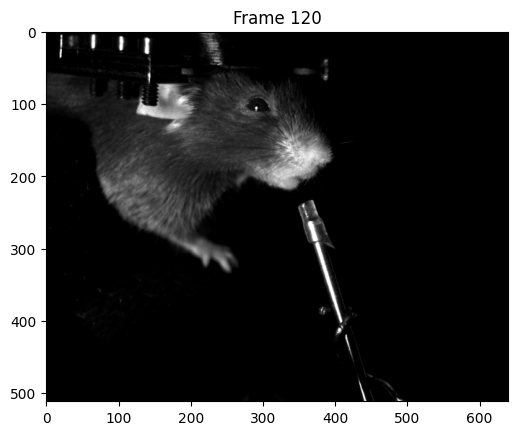

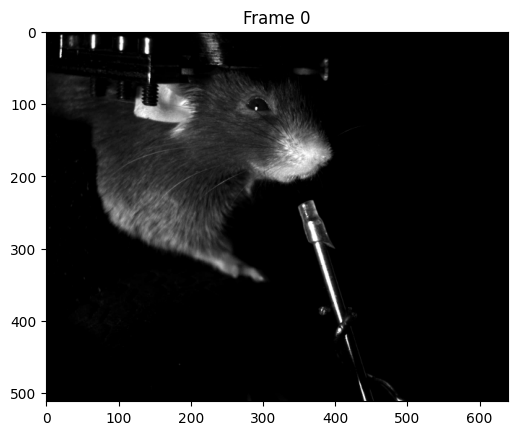

In [18]:
for path in paths:
    table_for_video = pd.read_csv(os.path.join(path, 'behavior')+'\\table_for_video.csv')
    video_path = os.path.join(path, 'behavior','raw_video_data') + '\\_iblrig_leftCamera.raw.avi'
    video_meta = get_video_meta(video_path, one=None)
    video_frame_rate = video_meta['fps']
    feedback_video_idx = find_frame_indices(table_for_video, video_frame_rate, (-1,1), 'feedback_times')
    #firstmove_video_idx = find_frame_indices(table_for_video, video_frame_rate, (0,2), 'firstMovement_times')
    reward_video_idx = feedback_video_idx[table_for_video['feedbackType'] == 1]
    reward_trial_idx = np.where(table_for_video['feedbackType'] == 1)[0]
    parts = os.path.normpath(path).split(os.sep)
    # Get the last two folders
    last_two = os.path.join(parts[-2], parts[-1]) if len(parts) > 1 else parts[-1]
    
    behavior_video_segments_path = os.path.join(r'D:\Edward_projects', 'behavior_video_segments', last_two)
    os.makedirs(behavior_video_segments_path, exist_ok=True)
    num_reward_trials = len(reward_video_idx)
    #trial_idx = [random.randint(0, num_reward_trials-1) for _ in range(10)]
    trial_idx = np.arange(num_reward_trials-4,num_reward_trials)
    for i in trial_idx:
        video_seg = get_video_frames_preload(video_path, frame_numbers=reward_video_idx[i], mask=np.s_[:, :, :], as_list=False,
                                    func=rgb_to_grayscale, quiet=False)
        video_seg = downsample_video_by_averaging(video_seg, (2,2))
        fig, ax = plt.subplots()

        def update(n):
            ax.clear()
            ax.imshow(video_seg[n], cmap='gray', vmin=0, vmax=255)
            ax.set_title(f"Frame {n}")

        anim = FuncAnimation(fig, update, frames=len(video_seg), interval=int(1000 / video_frame_rate))
        writer = FFMpegWriter(fps=video_frame_rate/2, metadata=dict(artist='Me'), bitrate=1800)
        segFileStr = "reward_" + str(reward_trial_idx[i]) +".mp4"
        savePath = os.path.join(behavior_video_segments_path,segFileStr)
        anim.save(savePath, writer=writer)

In [7]:
np.where(table_for_video['feedbackType'] == 1)

(array([  4,   5,   7,   8,   9,  10,  12,  13,  15,  20,  21,  23,  24,
         27,  29,  30,  31,  32,  33,  34,  35,  40,  41,  42,  44,  46,
         51,  52,  53,  54,  55,  58,  60,  63,  64,  65,  67,  69,  72,
         74,  76,  77,  78,  79,  80,  81,  82,  83,  86,  87,  89,  91,
         93,  97, 101, 102, 103, 105, 106, 112, 115, 116, 117, 123, 125,
        127, 129, 131, 133, 135, 139, 140, 141, 145, 146, 151, 153, 156,
        157, 160, 162, 164, 168, 171, 173, 174, 177, 178, 181, 184, 185,
        186, 188, 189, 194, 195, 196, 197, 198, 203, 204, 205, 214],
       dtype=int64),)

In [31]:
trial_idx

[141, 137, 52, 74, 105, 51, 76, 84, 66, 152]

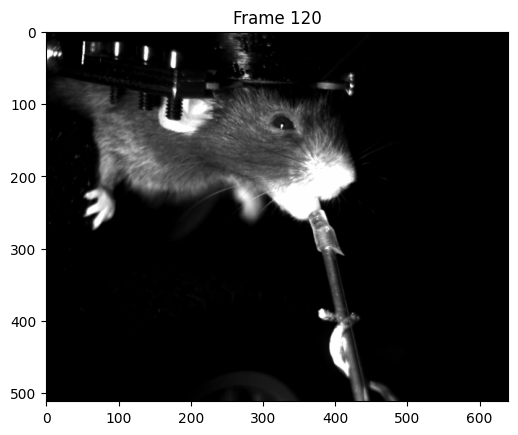

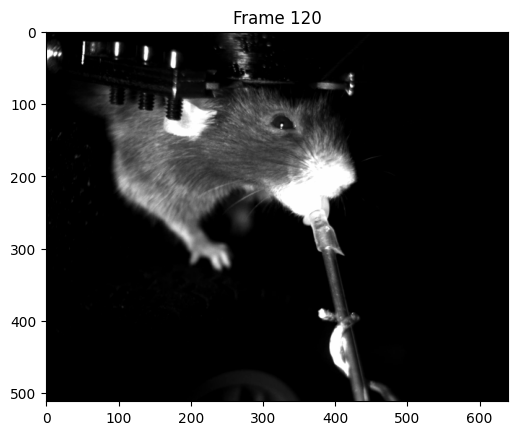

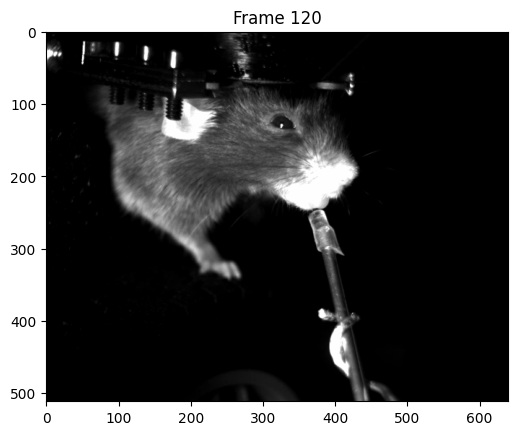

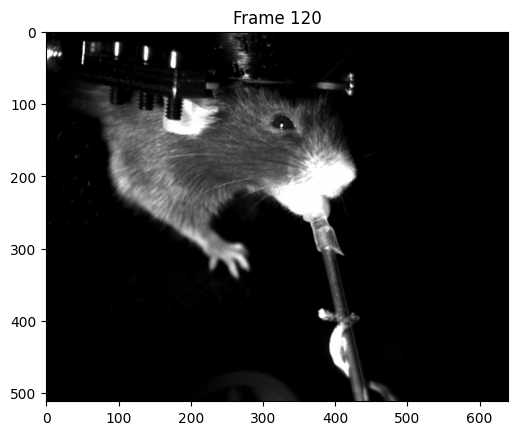

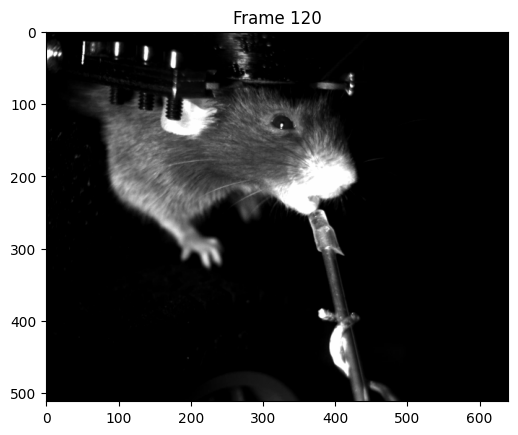

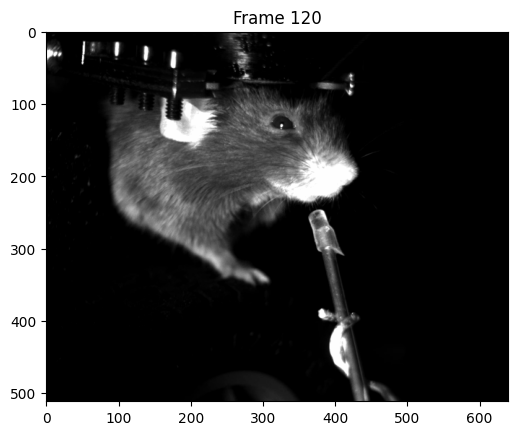

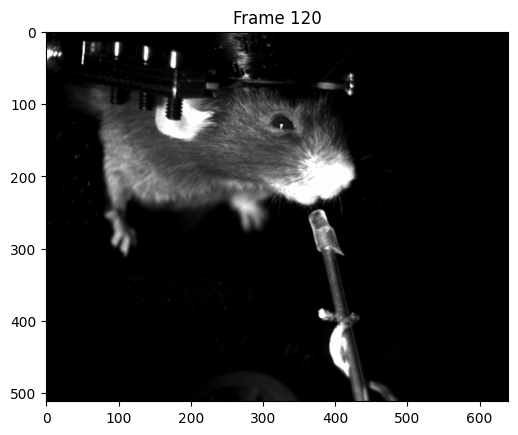

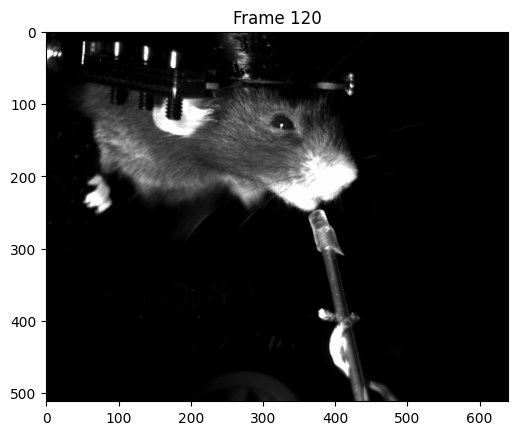

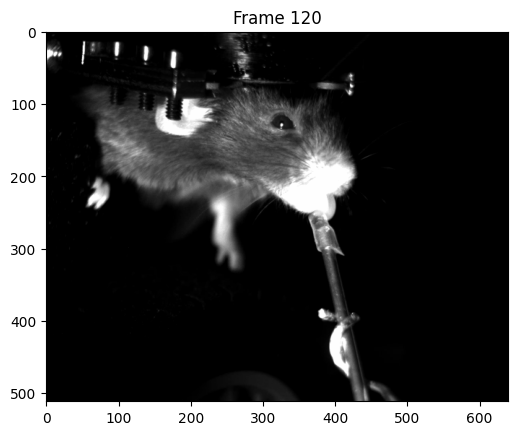

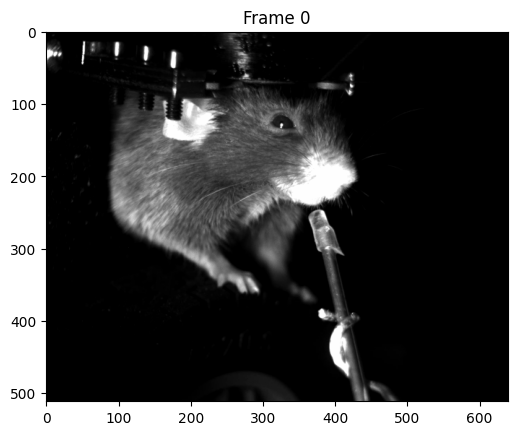

In [96]:
for i in range(210,220):
    video_seg = get_video_frames_preload(video_path, frame_numbers=reward_video_idx[i], mask=np.s_[:, :, :], as_list=False,
                                func=rgb_to_grayscale, quiet=False)
    video_seg = downsample_video_by_averaging(video_seg, (2,2))
    fig, ax = plt.subplots()

    def update(n):
        ax.clear()
        ax.imshow(video_seg[n], cmap='gray', vmin=0, vmax=255)
        ax.set_title(f"Frame {n}")

    anim = FuncAnimation(fig, update, frames=len(video_seg), interval=int(1000 / video_frame_rate))
    writer = FFMpegWriter(fps=video_frame_rate/2, metadata=dict(artist='Me'), bitrate=1800)
    segFileStr = "reward_" + str(i) +".mp4"
    savePath = os.path.join(behavior_video_segments_path,segFileStr)
    anim.save(savePath, writer=writer)

In [365]:
savePath = os.path.join(session_path, "behavior_video_segments", segFileStr)
savePath

'Z:\\TM_Lab\\Edward\\Data\\iblrig_data\\Subjects\\O_L3\\2024-03-26\\003\\behavior_video_segments\\reward_120.gif'

In [ ]:
fourcc = cv2.VideoWriter_fourcc(*'mp4v')  # or 'XVID'
segFileStr = 'reward_' + str(1) +'.mp4'
out = cv2.VideoWriter(os.path.join(session_path, 'behavior_video_segments', segFileStr), fourcc, 20.0, (video_seg.shape[2], video_seg.shape[1]), False)

for i in range(video_seg.shape[0]):
    out.write(video_seg[i].astype('uint8'))

out.release()  # Release everything if job is finished

# Embed the video in the notebook
from IPython.display import Video
Video("output.mp4")